In [15]:
import os

import scipy.stats

os.chdir('/cluster/home/bdayan/girgs/benji_src/notebooks/')

In [16]:
import sys
sys.path.append('../')
sys.path.append('../../nemo-eva/src/')

import os
os.getcwd()



'/cluster/home/bdayan/girgs/benji_src/notebooks'

In [3]:
from benji_girgs import utils, generation, points, fitting, mcmc
import os
import glob
import pandas as pd
import networkit

import networkit as nk

from girg_sampling import girgs

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"

import numpy as np
import matplotlib.pyplot as plt

import do_feature_extract
import networkx as nx


/cluster/scratch/bdayan/GIRG_data/socfb-Berkeley13.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-American75.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-UConn.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-MSU24.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Brandeis99.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Virginia63.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Duke14.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Indiana69.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Swarthmore42.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Simmons81.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Georgetown15.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Reed98.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-UC64.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Bowdoin47.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-UChicago30.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Middlebury45.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-MIT.SpaceOne
/cluster

In [25]:
def quick_quad_plot(g):
    a, B, pts = utils.get_diffmap_and_points(g, process=None, ds=2)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))


    # outputs = []
    # for k in range(0, ds):
    #     output = utils.cubify_dim(pts, k=k, quantile=0.05, perc_near=0.1)
    #     # pts[:, k] = output
    #     outputs.append(output)
    # pts_cuboid = np.stack(outputs, axis=-1)
    # _ = axes[0][0].hist2d(pts_cuboid[:, 0], pts_cuboid[:, 1], bins=30)
    # axes[0][0].set_title('cuboidify')


    pts_uniform = utils.uniformify_pts(pts)
    ax = axes[0]
    _ = ax.hist2d(pts_uniform[:, 0], pts_uniform[:, 1], bins=30)
    ax.set_title('uniformified')


    # outputs = []
    # for k in range(0, ds):
    #     output = utils.cubify_dim(pts, k=k, perc_near=0.1)
    #     outputs.append(output)
    # pts_cube = np.stack(outputs, axis=-1)
    #
    # axes[1][0].hist2d(pts_cube[:, 0], pts_cube[:, 1], bins=30)
    # axes[1][0].set_title('cubified')


    pts_temp = utils.restrict_and_uniformify_edges(pts, 0.05)
    ax = axes[1]
    ax.hist2d(pts_temp[:, 0], pts_temp[:, 1], bins=30)
    ax.set_title('restricted; outer uniformified')

    plt.axvline(0.05)
    plt.axvline(0.95)

    plt.axhline(0.05)
    plt.axhline(0.95)
    return pts_temp


In [5]:
import os
os.getcwd()
os.environ['DATA_PATH'] = '../../FE_FB_Torus_with_mixed/'

df = pd.read_csv(os.environ['DATA_PATH'] + '2-features/results.csv')

df.Info = df.Info.apply(lambda temp: {key: eval(var) for key, var in [x.split('=') for x in temp.split('|')]} if (type(temp) is str and '|' in temp) else {
    })
df['alpha'] = df.Info.apply(lambda x: x['alpha'] if 'alpha' in x else 1/float(x['t']) if 't' in x else None)

In [6]:
df.loc[df.Model == 'real-world'].sort_values('Nodes').loc[:, ['Graph', 'Nodes']]

Graph  Nodes
123      socfb-Caltech36    762
658         socfb-Reed98    962
312    socfb-Haverford76   1446
730      socfb-Simmons81   1510
776   socfb-Swarthmore42   1657
...                  ...    ...
1085          socfb-UF21  35111
856        socfb-Texas84  36364
634         socfb-Penn94  41536
608             socfb-OR  63392
27    socfb-wosn-friends  63392

[110 rows x 2 columns]

In [64]:
import importlib
importlib.reload(mcmc)
importlib.reload(utils)

<module 'benji_girgs.utils' from '../benji_girgs/utils.py'>

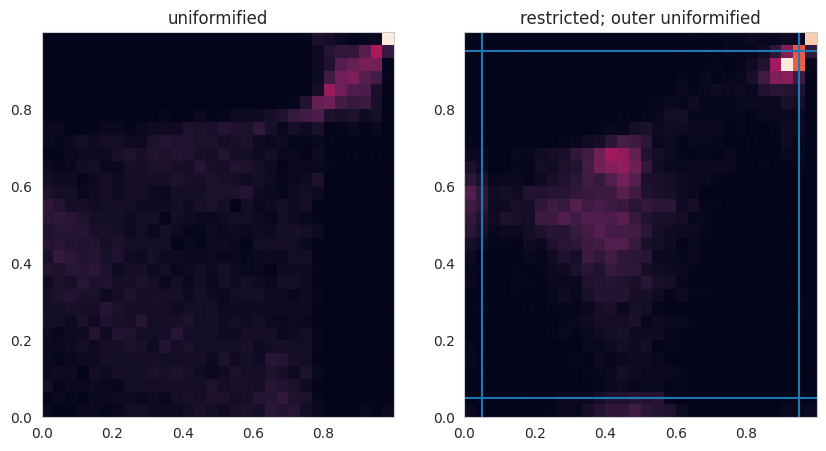

In [7]:
gd = list(filter(lambda x: x['Name'] == 'socfb-WashU32', do_feature_extract.graph_dicts))[0]
in_path = gd['FullPath']
in_path
name = gd['Name']
g = networkit.readGraph(in_path, networkit.Format.EdgeListSpaceOne)
g = utils.get_largest_component(g)
# nk.overview(g)
n = g.numberOfNodes()

quick_quad_plot(g)


4083


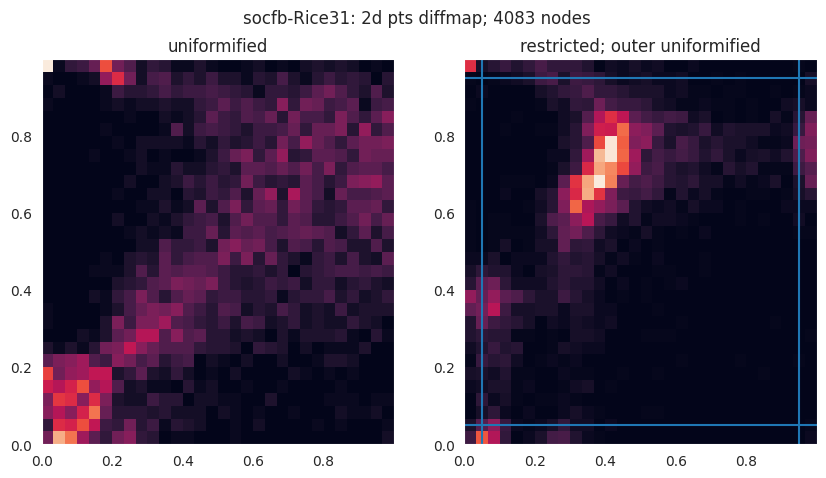

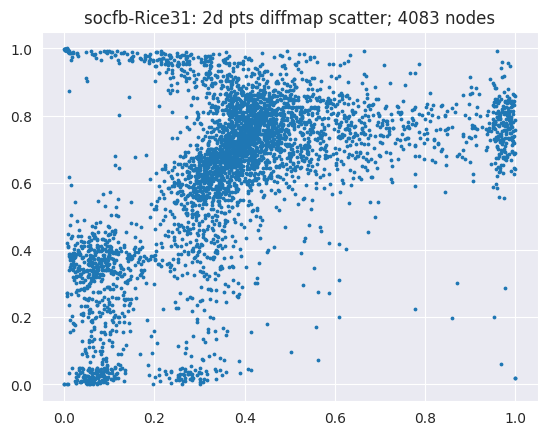

In [82]:
name = 'socfb-Rice31'
gd = list(filter(lambda x: x['Name'] == name, do_feature_extract.graph_dicts))[0]
in_path = gd['FullPath']
in_path
name = gd['Name']
g = networkit.readGraph(in_path, networkit.Format.EdgeListSpaceOne)
g = utils.get_largest_component(g)
# nk.overview(g)
n = g.numberOfNodes()
print(n)

pts = quick_quad_plot(g)
fig = plt.gcf()
fig.suptitle(f'{name}: 2d pts diffmap; {n} nodes')

plt.savefig(f'/cluster/home/bdayan/{name}_2ddiffmap_unif_vs_restrict')



import pickle
fpath = f'/cluster/home/bdayan/girgs/MCMC_ordered6/pickles/{name}-2d.pkl'
MC = pickle.load(open(fpath, 'rb'))

plt.figure()
plt.scatter(pts[:, 0], pts[:, 1], s=3.0)
plt.title(f'{name}: 2d pts diffmap scatter; {n} nodes')
plt.savefig(f'/cluster/home/bdayan/{name}_2ddiffmap_restrict_scatter')


[[1.         0.79716958]
 [0.79716958 1.        ]]
[[1.         0.87395915]
 [0.87395915 1.        ]]


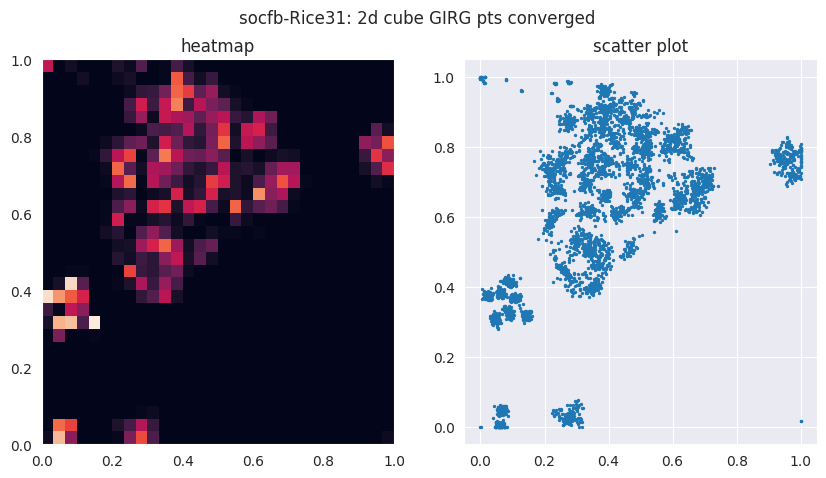

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
a, b = MC.pts[:, 0], 1-MC.pts[:, 1]
axes[0].hist2d(a, b, bins=30)
axes[0].set_title(f'heatmap')

axes[1].scatter(a, b, s=2.0)
axes[1].set_title(f'scatter plot')
fig.suptitle(f'{name}: 2d cube GIRG pts converged')

plt.savefig(f'/cluster/home/bdayan/{name}_2d_cube_GIRG_converged')

print(np.corrcoef(a, pts[:, 0]))
print(np.corrcoef(b, pts[:, 1]))

2250


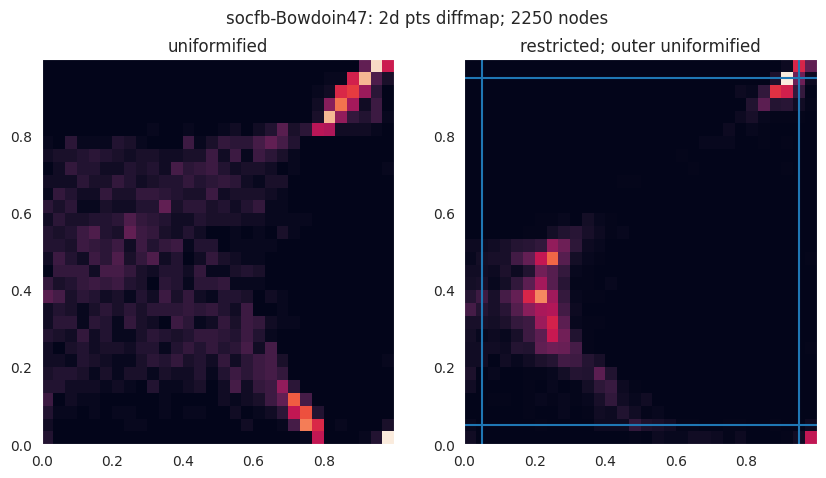

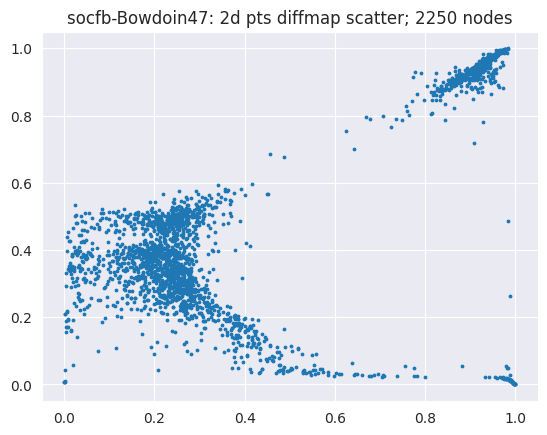

In [77]:
name = 'socfb-Bowdoin47'
gd = list(filter(lambda x: x['Name'] == name, do_feature_extract.graph_dicts))[0]
in_path = gd['FullPath']
in_path
name = gd['Name']
g = networkit.readGraph(in_path, networkit.Format.EdgeListSpaceOne)
g = utils.get_largest_component(g)
# nk.overview(g)
n = g.numberOfNodes()
print(n)

pts = quick_quad_plot(g)
fig = plt.gcf()
fig.suptitle(f'{name}: 2d pts diffmap; {n} nodes')

plt.savefig(f'/cluster/home/bdayan/{name}_2ddiffmap_unif_vs_restrict')



import pickle
fpath = f'/cluster/home/bdayan/girgs/MCMC_ordered6/pickles/{name}-2d.pkl'
MC = pickle.load(open(fpath, 'rb'))

plt.figure()
plt.scatter(pts[:, 0], pts[:, 1], s=3.0)
plt.title(f'{name}: 2d pts diffmap scatter; {n} nodes')
plt.savefig(f'/cluster/home/bdayan/{name}_2ddiffmap_restrict_scatter')

[[1.       0.932626]
 [0.932626 1.      ]]
[[1.         0.97098809]
 [0.97098809 1.        ]]


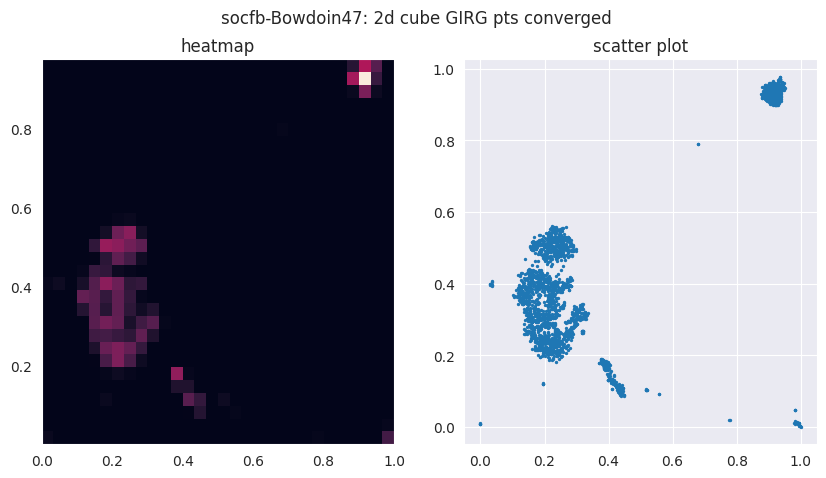

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
a, b = 1-MC.pts[:, 0], 1-MC.pts[:, 1]
axes[0].hist2d(a, b, bins=30)
axes[0].set_title(f'heatmap')

axes[1].scatter(a, b, s=2.0)
axes[1].set_title(f'scatter plot')
fig.suptitle(f'{name}: 2d cube GIRG pts converged')

plt.savefig(f'/cluster/home/bdayan/{name}_2d_cube_GIRG_converged')

print(np.corrcoef(a, pts[:, 0]))
print(np.corrcoef(b, pts[:, 1]))

1446


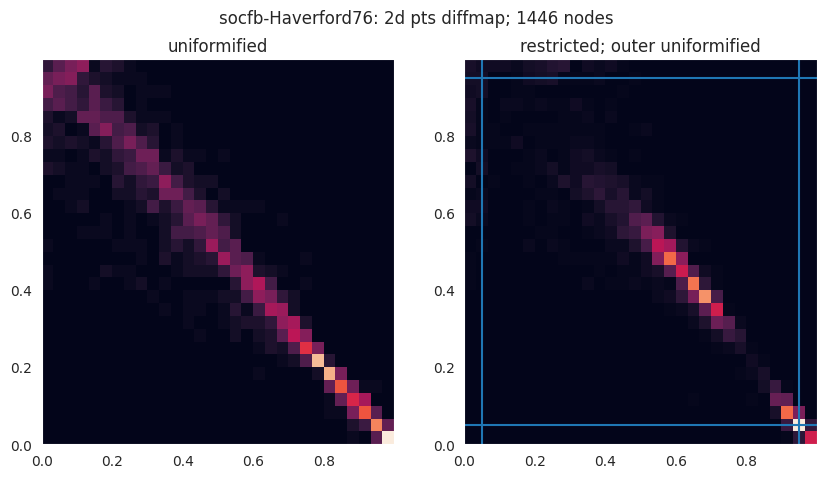

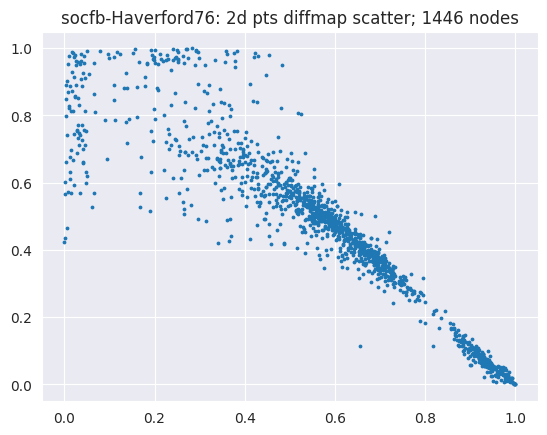

In [80]:
name = 'socfb-Haverford76'
gd = list(filter(lambda x: x['Name'] == name, do_feature_extract.graph_dicts))[0]
in_path = gd['FullPath']
in_path
name = gd['Name']
g = networkit.readGraph(in_path, networkit.Format.EdgeListSpaceOne)
g = utils.get_largest_component(g)
# nk.overview(g)
n = g.numberOfNodes()
print(n)

pts = quick_quad_plot(g)
fig = plt.gcf()
fig.suptitle(f'{name}: 2d pts diffmap; {n} nodes')

plt.savefig(f'/cluster/home/bdayan/{name}_2ddiffmap_unif_vs_restrict')



import pickle
fpath = f'/cluster/home/bdayan/girgs/MCMC_ordered6/pickles/{name}-2d.pkl'
MC = pickle.load(open(fpath, 'rb'))

plt.figure()
plt.scatter(pts[:, 0], pts[:, 1], s=3.0)
plt.title(f'{name}: 2d pts diffmap scatter; {n} nodes')
plt.savefig(f'/cluster/home/bdayan/{name}_2ddiffmap_restrict_scatter')

[[1.         0.89661255]
 [0.89661255 1.        ]]
[[1.         0.93509435]
 [0.93509435 1.        ]]


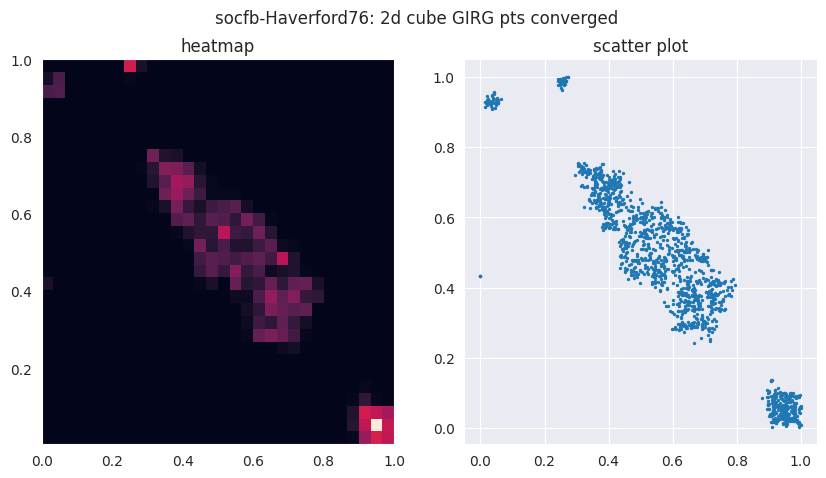

In [81]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
a, b = 1-MC.pts[:, 0], 1-MC.pts[:, 1]
axes[0].hist2d(a, b, bins=30)
axes[0].set_title(f'heatmap')

axes[1].scatter(a, b, s=2.0)
axes[1].set_title(f'scatter plot')
fig.suptitle(f'{name}: 2d cube GIRG pts converged')

plt.savefig(f'/cluster/home/bdayan/{name}_2d_cube_GIRG_converged')

print(np.corrcoef(a, pts[:, 0]))
print(np.corrcoef(b, pts[:, 1]))

In [36]:
df.loc[df.Model == 'real-world'].sort_values('Nodes').loc[:, ['Graph', 'Nodes']].iloc[[3, 6, 10, 15]].iter

Graph  Nodes
730   socfb-Simmons81   1510
1     socfb-Bowdoin47   2250
220  socfb-Williams40   2788
825    socfb-Vassar85   3068

In [40]:
for i, (name, nodes) in df.loc[df.Model == 'real-world'].sort_values('Nodes').loc[:, ['Graph', 'Nodes']].iloc[[3, 6, 10, 15]].iterrows():
    print(name, nodes)

socfb-Simmons81 1510
socfb-Bowdoin47 2250
socfb-Williams40 2788
socfb-Vassar85 3068


In [39]:
nodes

Graph    socfb-Vassar85
Nodes              3068
Name: 825, dtype: object

socfb-Simmons81 1510


'/cluster/scratch/bdayan/GIRG_data/socfb-Simmons81.SpaceOne'

socfb-Bowdoin47 2250


'/cluster/scratch/bdayan/GIRG_data/socfb-Bowdoin47.SpaceOne'

socfb-Williams40 2788


'/cluster/scratch/bdayan/GIRG_data/socfb-Williams40.SpaceOne'

socfb-Vassar85 3068


'/cluster/scratch/bdayan/GIRG_data/socfb-Vassar85.SpaceOne'

socfb-Rice31 4083


'/cluster/scratch/bdayan/GIRG_data/socfb-Rice31.SpaceOne'

socfb-Vermont70 7322


'/cluster/scratch/bdayan/GIRG_data/socfb-Vermont70.SpaceOne'

socfb-Maine59 9065


'/cluster/scratch/bdayan/GIRG_data/socfb-Maine59.SpaceOne'

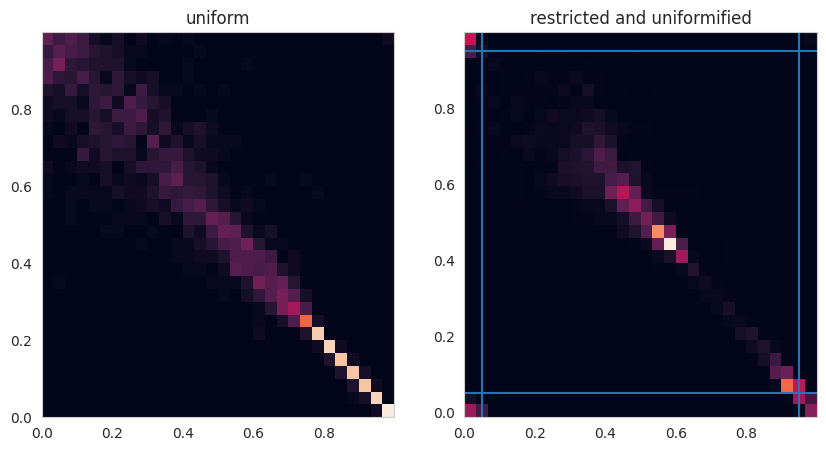

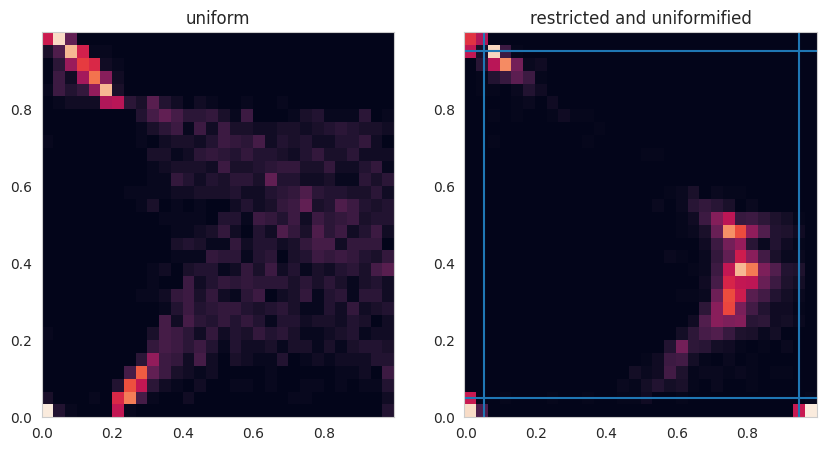

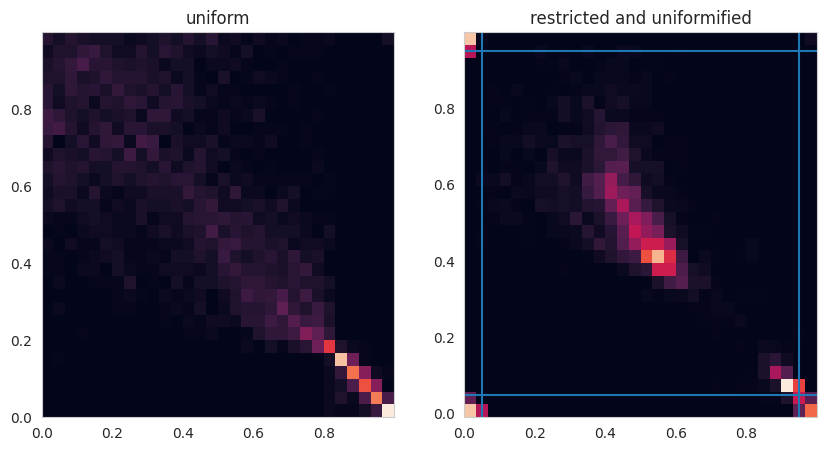

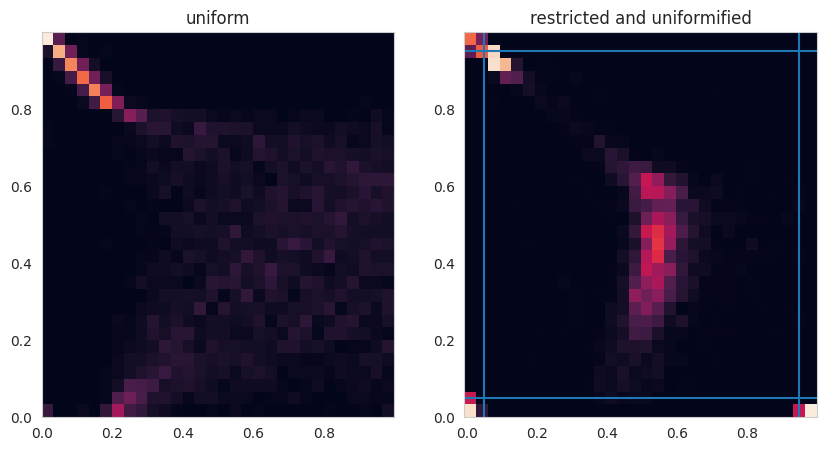

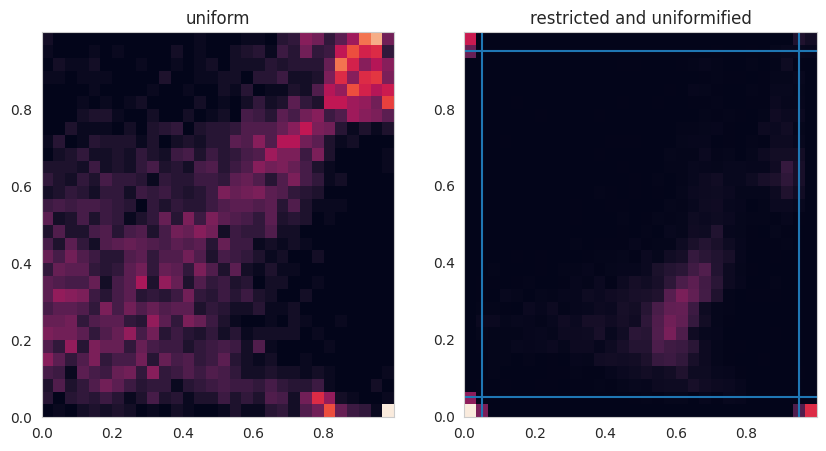

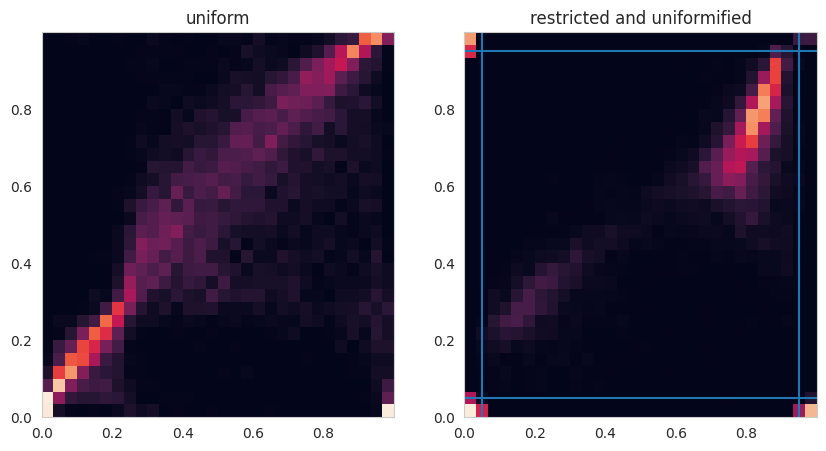

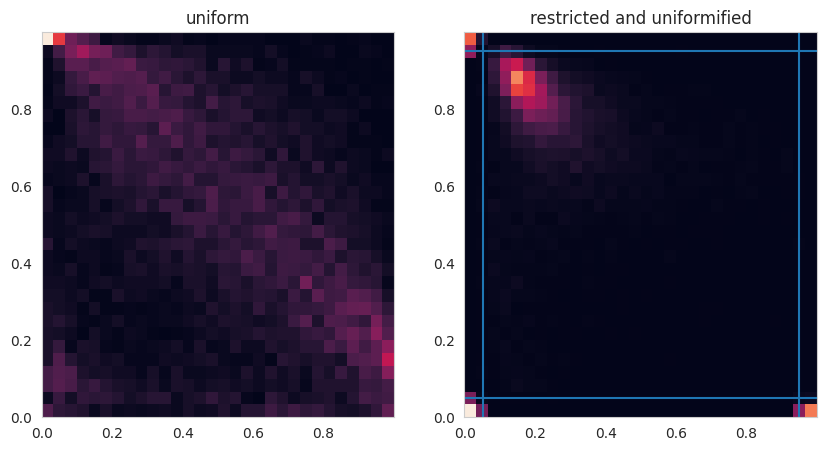

In [41]:
for i, (name, nodes) in df.loc[df.Model == 'real-world'].sort_values('Nodes').loc[:, ['Graph', 'Nodes']].iloc[[3, 6, 10, 15, 25, 40, 50]].iterrows():
    print(name, nodes)
    gd = list(filter(lambda x: x['Name'] == name, do_feature_extract.graph_dicts))[0]
    in_path = gd['FullPath']
    in_path
    name = gd['Name']
    g = networkit.readGraph(in_path, networkit.Format.EdgeListSpaceOne)
    g = utils.get_largest_component(g)
    # nk.overview(g)
    n = g.numberOfNodes()

    quick_quad_plot(g)
    plt.show()


socfb-Simmons81 1510


'/cluster/scratch/bdayan/GIRG_data/socfb-Simmons81.SpaceOne'

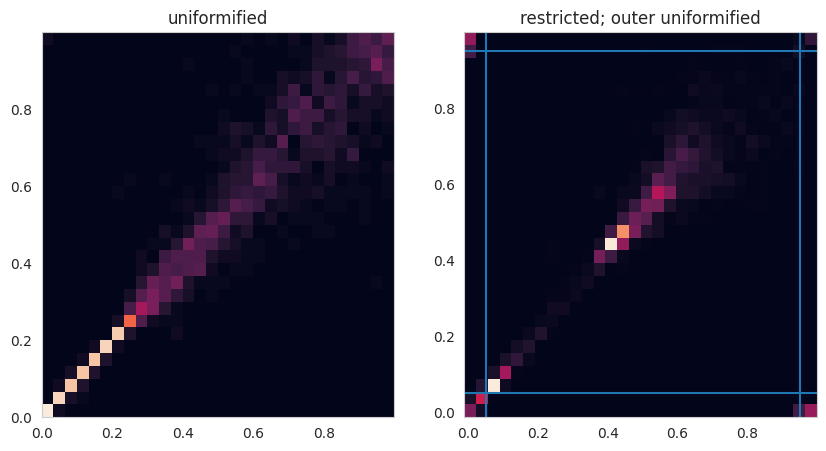

socfb-Bowdoin47 2250


'/cluster/scratch/bdayan/GIRG_data/socfb-Bowdoin47.SpaceOne'

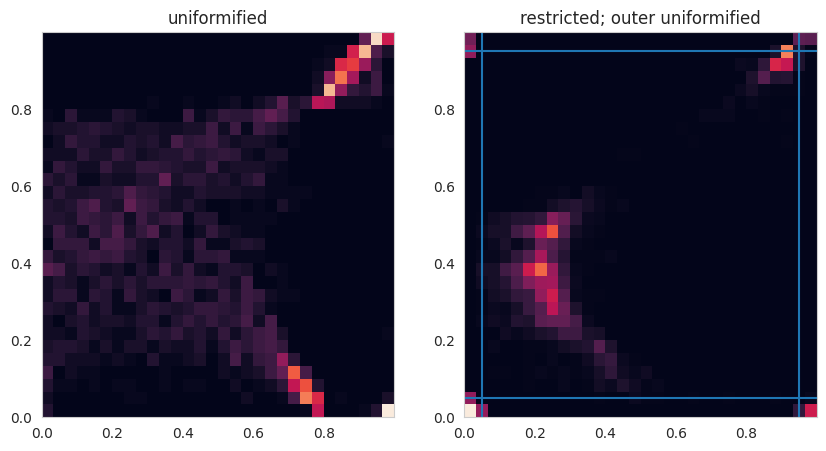

socfb-Williams40 2788


'/cluster/scratch/bdayan/GIRG_data/socfb-Williams40.SpaceOne'

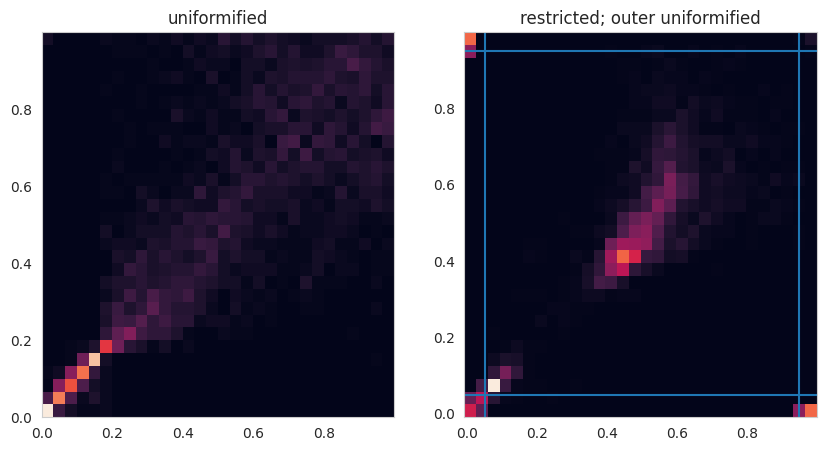

socfb-Vassar85 3068


'/cluster/scratch/bdayan/GIRG_data/socfb-Vassar85.SpaceOne'

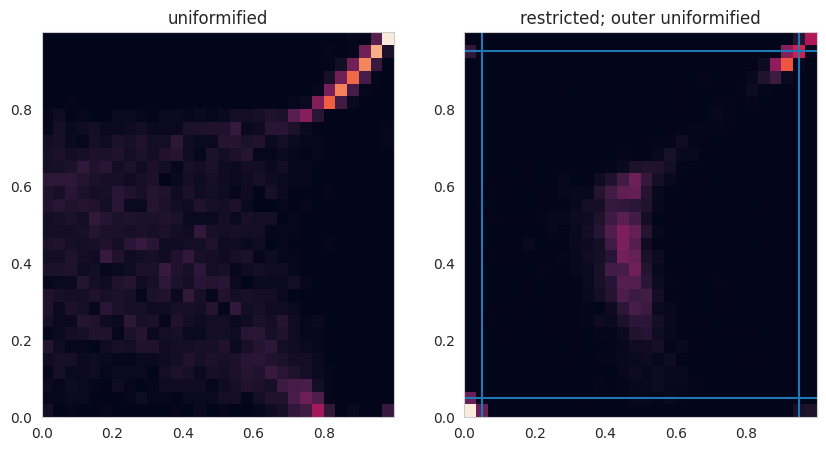

socfb-Rice31 4083


'/cluster/scratch/bdayan/GIRG_data/socfb-Rice31.SpaceOne'

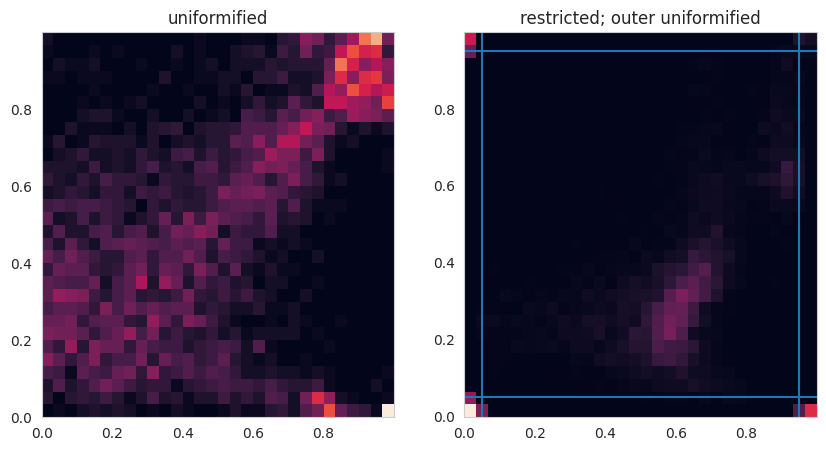

socfb-Vermont70 7322


'/cluster/scratch/bdayan/GIRG_data/socfb-Vermont70.SpaceOne'

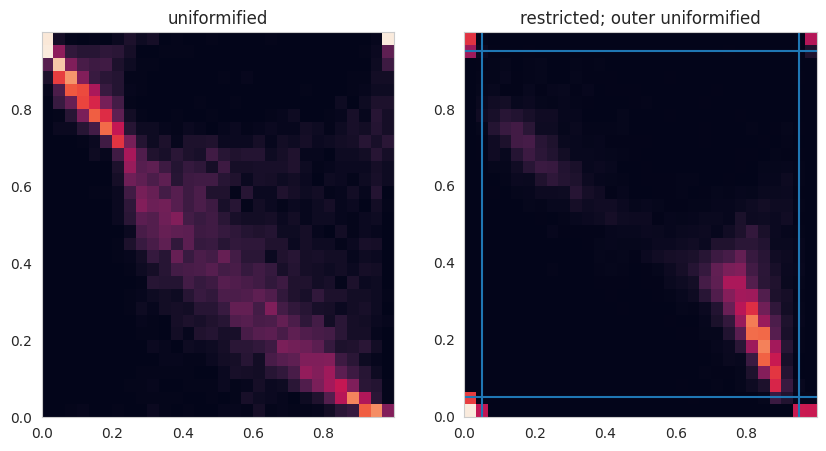

socfb-Maine59 9065


'/cluster/scratch/bdayan/GIRG_data/socfb-Maine59.SpaceOne'

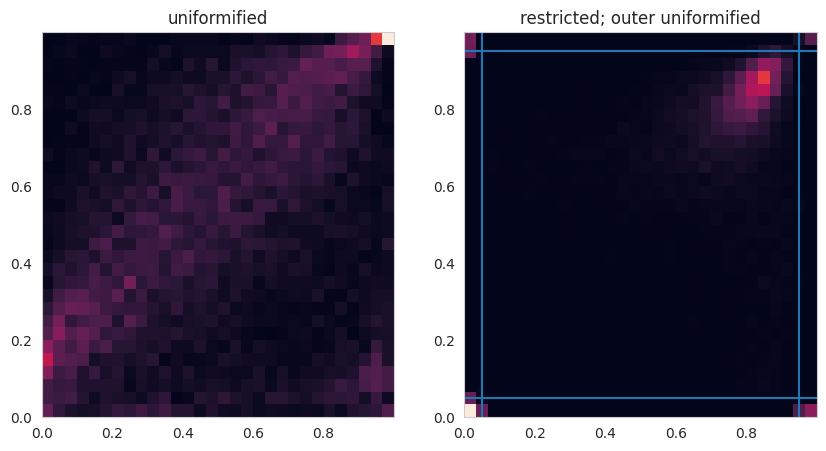

In [44]:
for i, (name, nodes) in df.loc[df.Model == 'real-world'].sort_values('Nodes').loc[:, ['Graph', 'Nodes']].iloc[[3, 6, 10, 15, 25, 40, 50]].iterrows():
    print(name, nodes)
    gd = list(filter(lambda x: x['Name'] == name, do_feature_extract.graph_dicts))[0]
    in_path = gd['FullPath']
    in_path
    name = gd['Name']
    g = networkit.readGraph(in_path, networkit.Format.EdgeListSpaceOne)
    g = utils.get_largest_component(g)
    # nk.overview(g)
    n = g.numberOfNodes()

    quick_quad_plot(g)
    plt.show()


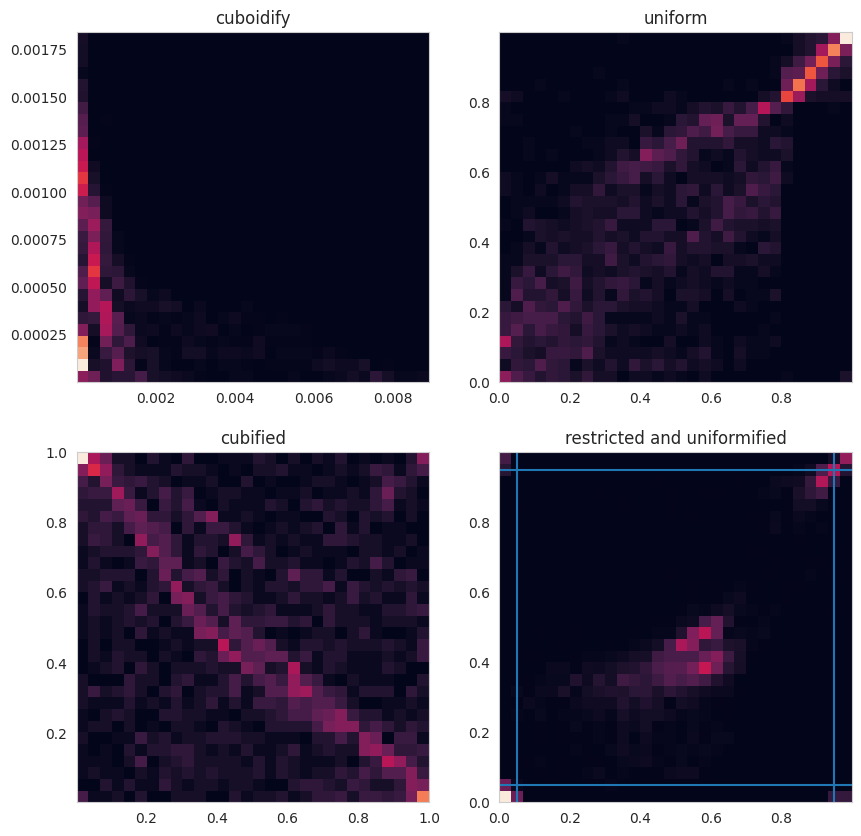

In [11]:
a, B, pts = utils.get_diffmap_and_points(g, process=None, ds=2)
ds = 2


fig, axes = plt.subplots(2, 2, figsize=(10, 10))


# outputs = []
# for k in range(0, ds):
#     output = utils.cubify_dim(pts, k=k, quantile=0.05, perc_near=0.1)
#     # pts[:, k] = output
#     outputs.append(output)
# pts_cuboid = np.stack(outputs, axis=-1)
# _ = axes[0][0].hist2d(pts_cuboid[:, 0], pts_cuboid[:, 1], bins=30)
# axes[0][0].set_title('cuboidify')


pts_uniform = utils.uniformify_pts(pts)
_ = axes[0][1].hist2d(pts_uniform[:, 0], pts_uniform[:, 1], bins=30)
axes[0][1].set_title('uniform')


outputs = []
for k in range(0, ds):
    output = utils.cubify_dim(pts, k=k, perc_near=0.1)
    outputs.append(output)
pts_cube = np.stack(outputs, axis=-1)

axes[1][0].hist2d(pts_cube[:, 0], pts_cube[:, 1], bins=30)
axes[1][0].set_title('cubified')


pts_temp = utils.restrict_and_uniformify_edges(pts, 0.05)
axes[1][1].hist2d(pts_temp[:, 0], pts_temp[:, 1], bins=30)
axes[1][1].set_title('restricted and uniformified')

plt.axvline(0.05)
plt.axvline(0.95)

plt.axhline(0.05)
plt.axhline(0.95)

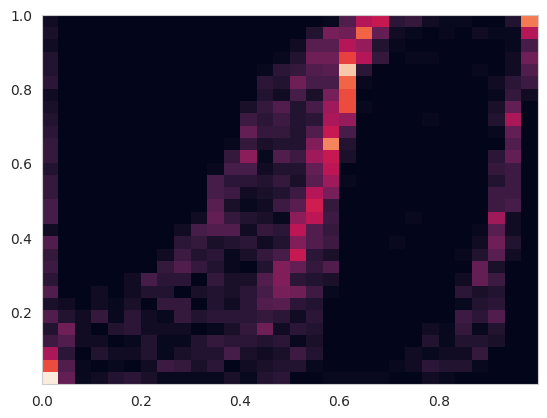

In [18]:
_ = plt.hist2d(pts_temp[:, 0], pts_cube[:, 0], bins=30)

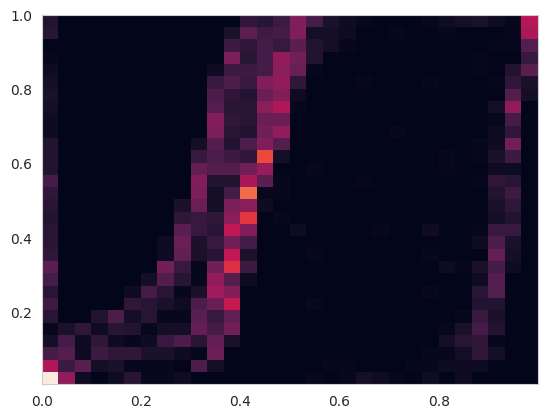

In [22]:
_ = plt.hist2d(pts_temp[:, 1], pts_cube[:, 1], bins=30)
# _ = plt.hist2d(np.array([0, 1, 2, 3, 4, 5]), np.array([-5, -6, -7, -8, -8, -9]))

In [14]:
temp = [[0,1,2,3], [4,5,6,7]]
np.stack(temp, axis=-1)

array([[0, 4],
       [1, 5],
       [2, 6],
       [3, 7]])

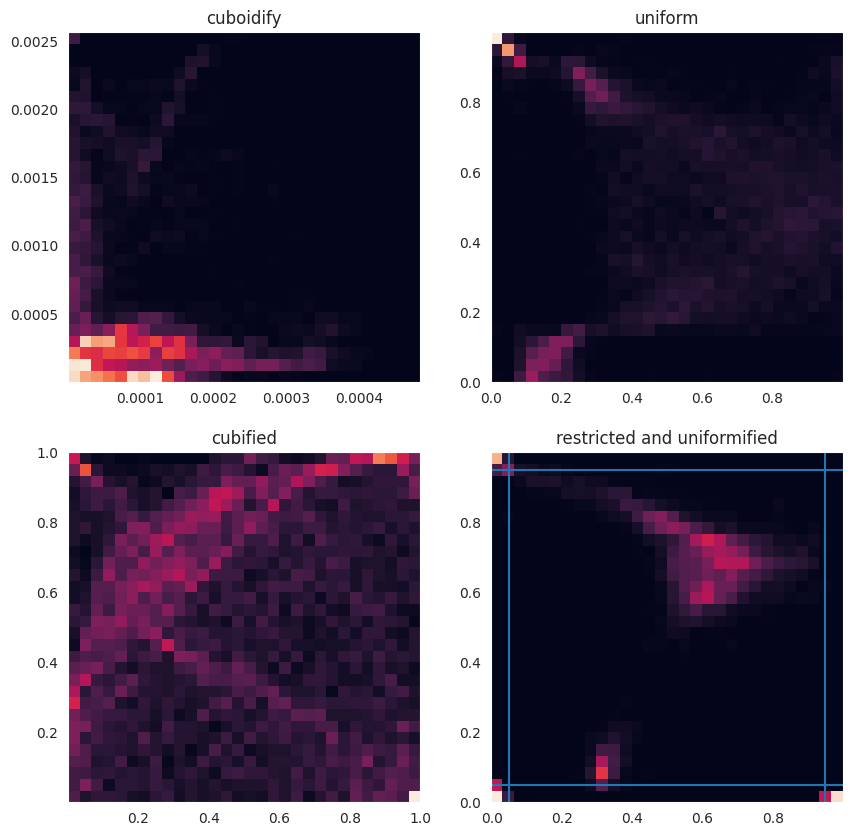

In [75]:
gd = list(filter(lambda x: x['Name'] == 'socfb-Yale4', do_feature_extract.graph_dicts))[0]
in_path = gd['FullPath']
in_path
name = gd['Name']
g = networkit.readGraph(in_path, networkit.Format.EdgeListSpaceOne)
g = utils.get_largest_component(g)
# nk.overview(g)
n = g.numberOfNodes()

quick_quad_plot(g)


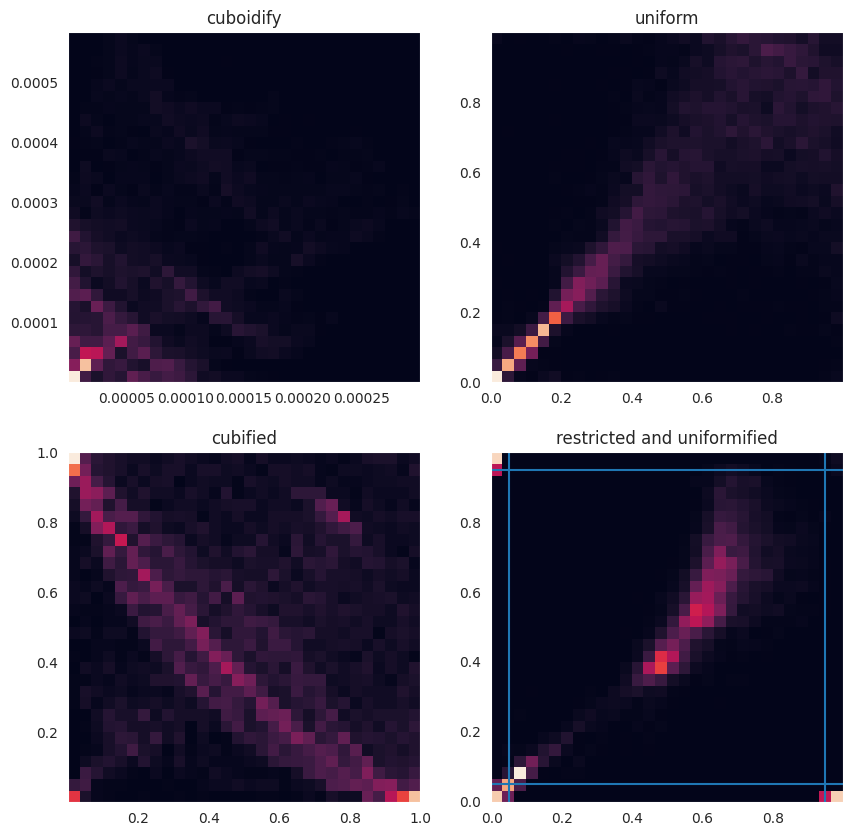

In [76]:
gd = list(filter(lambda x: x['Name'] == 'socfb-Brown11', do_feature_extract.graph_dicts))[0]
in_path = gd['FullPath']
in_path
name = gd['Name']
g = networkit.readGraph(in_path, networkit.Format.EdgeListSpaceOne)
g = utils.get_largest_component(g)
# nk.overview(g)
n = g.numberOfNodes()

quick_quad_plot(g)


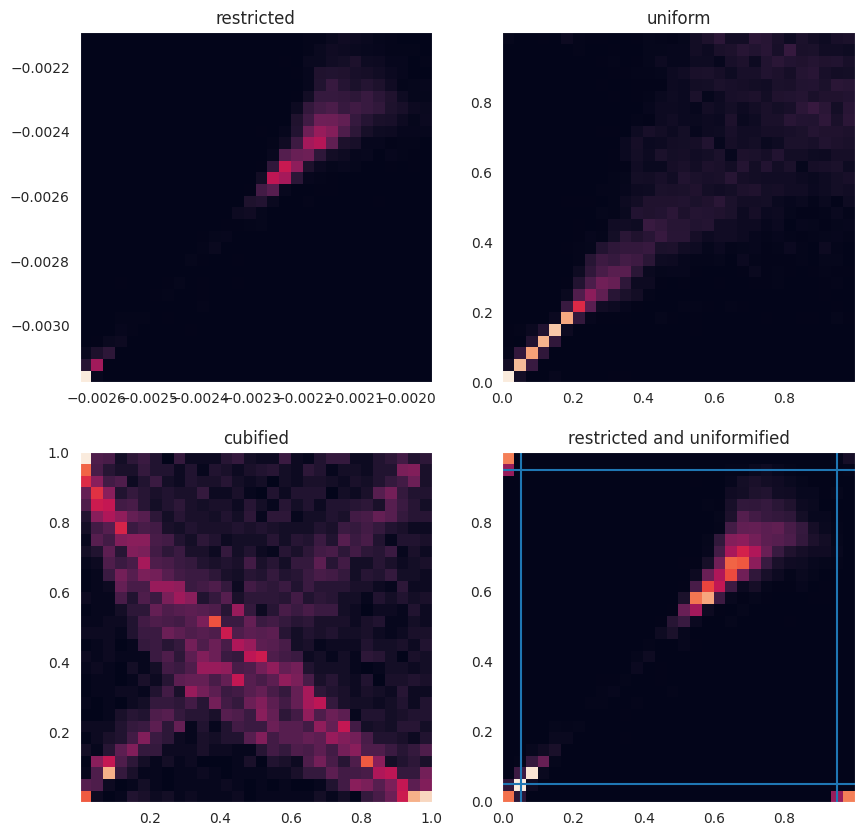

In [65]:
gd = list(filter(lambda x: x['Name'] == 'socfb-Tufts18', do_feature_extract.graph_dicts))[0]
in_path = gd['FullPath']
in_path
name = gd['Name']
g = networkit.readGraph(in_path, networkit.Format.EdgeListSpaceOne)
g = utils.get_largest_component(g)
# nk.overview(g)
n = g.numberOfNodes()

a, B, pts = utils.get_diffmap_and_points(g, process=None, ds=2)

pts_restricted, restriction = utils.restrict_to_quantiles(pts, 0.05)
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
_ = axes[0][0].hist2d(pts_restricted[:, 0], pts_restricted[:, 1], bins=30)
axes[0][0].set_title('restricted')

pts_uniform = utils.uniformify_pts(pts)
_ = axes[0][1].hist2d(pts_uniform[:, 0], pts_uniform[:, 1], bins=30)
axes[0][1].set_title('uniform')

pts_temp = utils.restrict_and_uniformify_edges(pts, 0.05)

ds=2
outputs = []
for k in range(0, ds):
    output = utils.cubify_dim(pts, k=k, perc_near=0.1)
    outputs.append(output)
pts_cube = np.stack(outputs, axis=-1)

axes[1][0].hist2d(pts_cube[:, 0], pts_cube[:, 1], bins=30)
axes[1][0].set_title('cubified')

axes[1][1].hist2d(pts_temp[:, 0], pts_temp[:, 1], bins=30)
axes[1][1].set_title('restricted and uniformified')

plt.axvline(0.05)
plt.axvline(0.95)

plt.axhline(0.05)
plt.axhline(0.95)


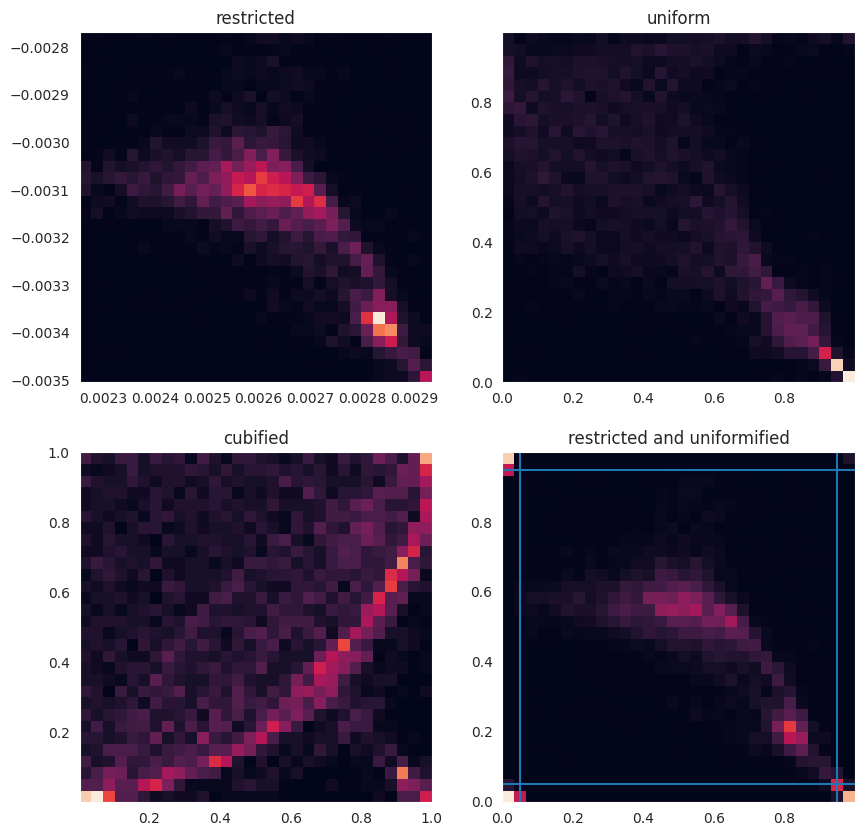

In [67]:
gd = list(filter(lambda x: x['Name'] == 'socfb-JohnsHopkins55', do_feature_extract.graph_dicts))[0]
in_path = gd['FullPath']
in_path
name = gd['Name']
g = networkit.readGraph(in_path, networkit.Format.EdgeListSpaceOne)
g = utils.get_largest_component(g)
# nk.overview(g)
n = g.numberOfNodes()

quick_quad_plot(g)


Text(0.5, 1.0, 'uniform')

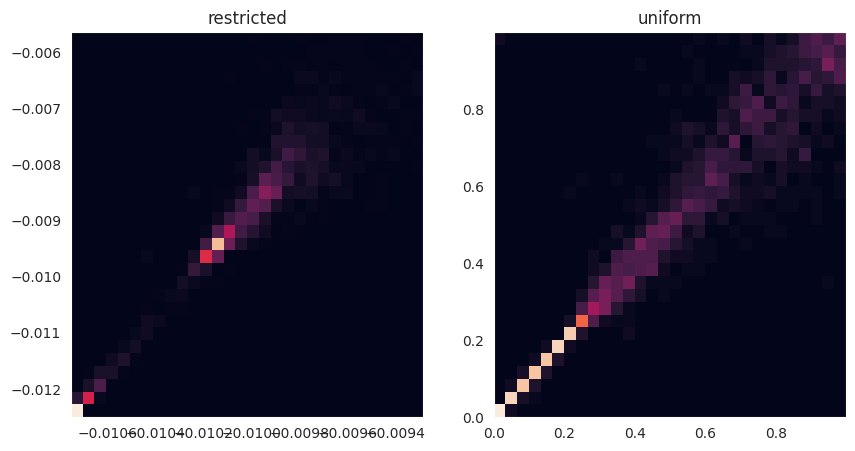

In [45]:
gd = list(filter(lambda x: x['Name'] == 'socfb-Simmons81', do_feature_extract.graph_dicts))[0]
in_path = gd['FullPath']
in_path
name = gd['Name']
g = networkit.readGraph(in_path, networkit.Format.EdgeListSpaceOne)
g = utils.get_largest_component(g)
# nk.overview(g)
n = g.numberOfNodes()

a, B, pts = utils.get_diffmap_and_points(g, process=None, ds=2)

pts_restricted, restriction = utils.restrict_to_quantiles(pts, 0.05)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
_ = axes[0].hist2d(pts_restricted[:, 0], pts_restricted[:, 1], bins=30)
axes[0].set_title('restricted')

pts_uniform = utils.uniformify_pts(pts)
_ = axes[1].hist2d(pts_uniform[:, 0], pts_uniform[:, 1], bins=30)
axes[1].set_title('uniform')


Text(0.5, 1.0, 'uniform')

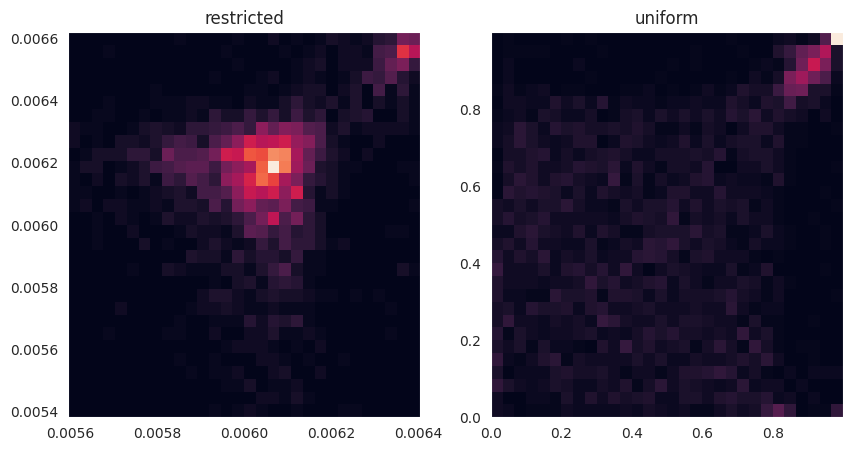

In [44]:
gd = list(filter(lambda x: x['Name'] == 'socfb-Smith60', do_feature_extract.graph_dicts))[0]
in_path = gd['FullPath']
in_path
name = gd['Name']
g = networkit.readGraph(in_path, networkit.Format.EdgeListSpaceOne)
g = utils.get_largest_component(g)
# nk.overview(g)
n = g.numberOfNodes()

a, B, pts = utils.get_diffmap_and_points(g, process=None, ds=2)

pts_restricted, restriction = utils.restrict_to_quantiles(pts, 0.05)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
_ = axes[0].hist2d(pts_restricted[:, 0], pts_restricted[:, 1], bins=30)
axes[0].set_title('restricted')

pts_uniform = utils.uniformify_pts(pts)
_ = axes[1].hist2d(pts_uniform[:, 0], pts_uniform[:, 1], bins=30)
axes[1].set_title('uniform')


Text(0.5, 1.0, 'uniform')

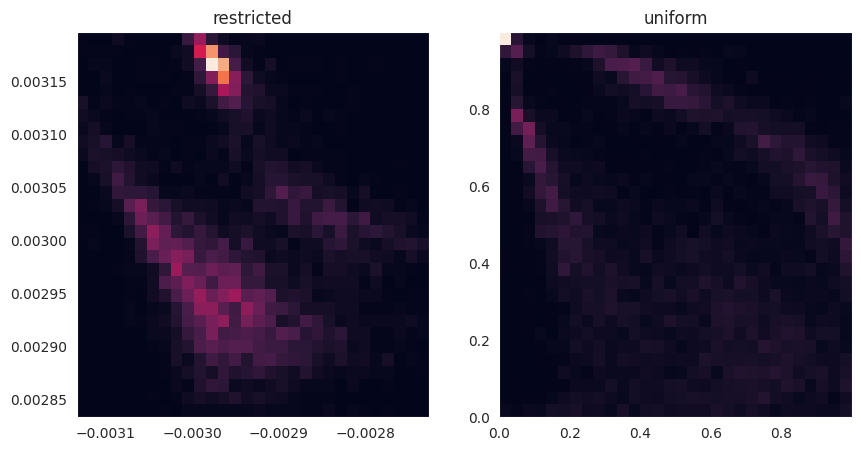

In [46]:
gd = list(filter(lambda x: x['Name'] == 'socfb-Princeton12', do_feature_extract.graph_dicts))[0]
in_path = gd['FullPath']
in_path
name = gd['Name']
g = networkit.readGraph(in_path, networkit.Format.EdgeListSpaceOne)
g = utils.get_largest_component(g)
# nk.overview(g)
n = g.numberOfNodes()

a, B, pts = utils.get_diffmap_and_points(g, process=None, ds=2)

pts_restricted, restriction = utils.restrict_to_quantiles(pts, 0.05)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
_ = axes[0].hist2d(pts_restricted[:, 0], pts_restricted[:, 1], bins=30)
axes[0].set_title('restricted')

pts_uniform = utils.uniformify_pts(pts)
_ = axes[1].hist2d(pts_uniform[:, 0], pts_uniform[:, 1], bins=30)
axes[1].set_title('uniform')


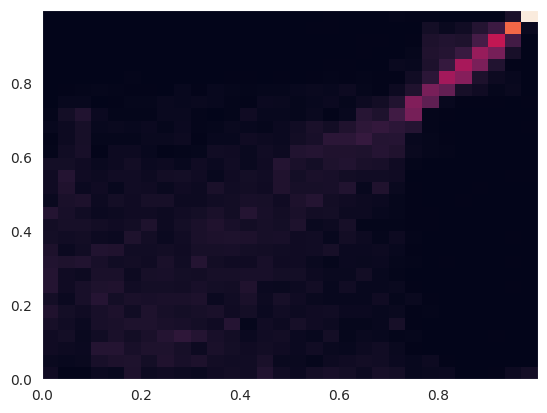

In [15]:
gd = list(filter(lambda x: x['Name'] == 'socfb-CMU', do_feature_extract.graph_dicts))[0]
in_path = gd['FullPath']
in_path
name = gd['Name']
g = networkit.readGraph(in_path, networkit.Format.EdgeListSpaceOne)
g = utils.get_largest_component(g)
# nk.overview(g)
n = g.numberOfNodes()

a, B, pts = utils.get_diffmap_and_points(g, process='uniformify', ds=2)

plt.figure()
_ = plt.hist2d(pts[:, 0], pts[:, 1], bins=30)


In [16]:
utils.restrict_to_quantiles

<function benji_girgs.utils.restrict_to_quantiles(pts, quantile=0.05)>

In [32]:
import importlib
importlib.reload(utils)

<module 'benji_girgs.utils' from '../benji_girgs/utils.py'>

In [33]:
a, B, pts = utils.get_diffmap_and_points(g, process=None, ds=2)

pts_restricted, restriction = utils.restrict_to_quantiles(pts, 0.05)

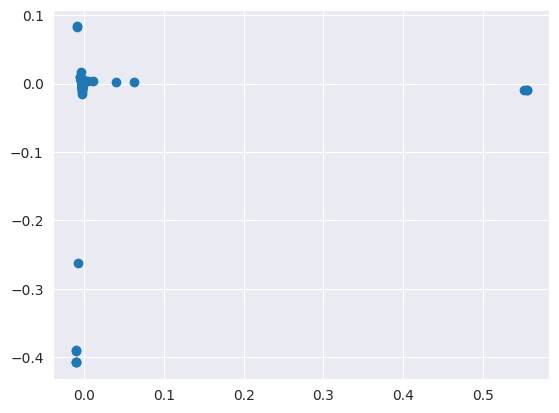

In [34]:
plt.figure()
_ = plt.scatter(pts[:, 0], pts[:, 1])

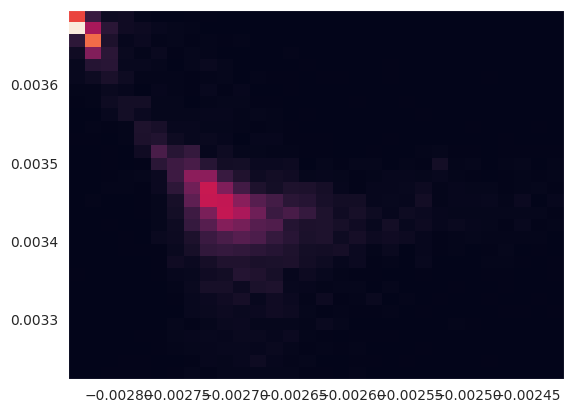

In [35]:
plt.figure()
_ = plt.hist2d(pts_restricted[:, 0], pts_restricted[:, 1], bins=30)

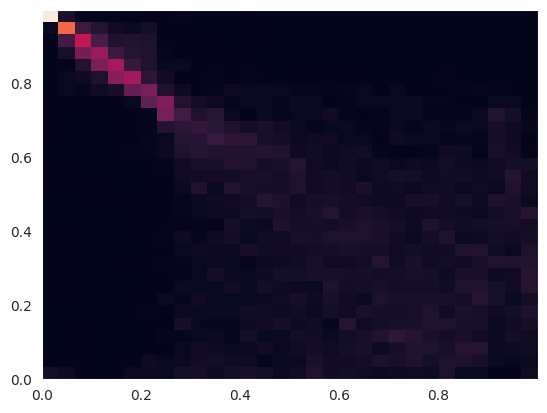

In [36]:
pts_uniform = utils.uniformify_pts(pts)
plt.figure()
_ = plt.hist2d(pts_uniform[:, 0], pts_uniform[:, 1], bins=30)

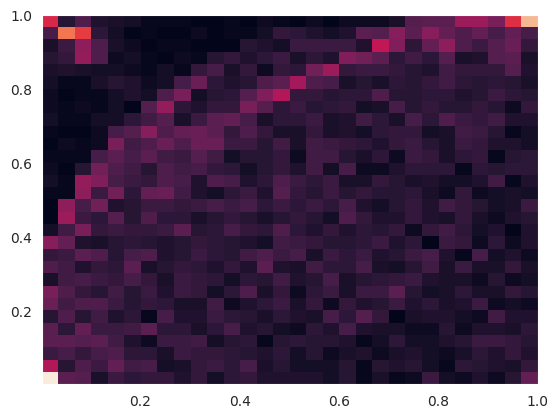

In [37]:
outputs = []
ds = 2
for k in range(0, ds):
    output = utils.cubify_dim(pts, k=k, perc_near=0.1)
    outputs.append(output)
pts_cube = np.stack(outputs, axis=-1)

plt.figure()
_ = plt.hist2d(pts_cube[:, 0], pts_cube[:, 1], bins=30)

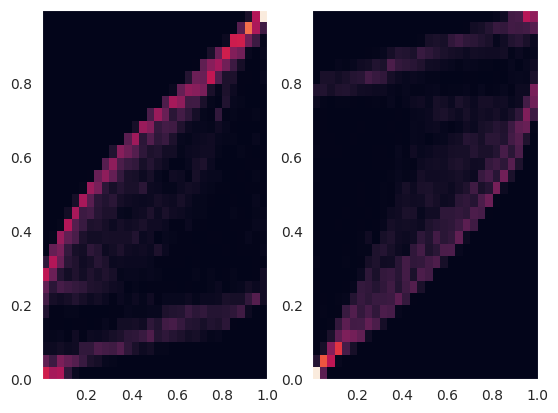

In [38]:
fig, axes = plt.subplots(1, 2)
_ = axes[0].hist2d(pts_cube[:, 0], pts_uniform[:, 0], bins=30)
_ = axes[1].hist2d(pts_cube[:, 1], pts_uniform[:, 1], bins=30)

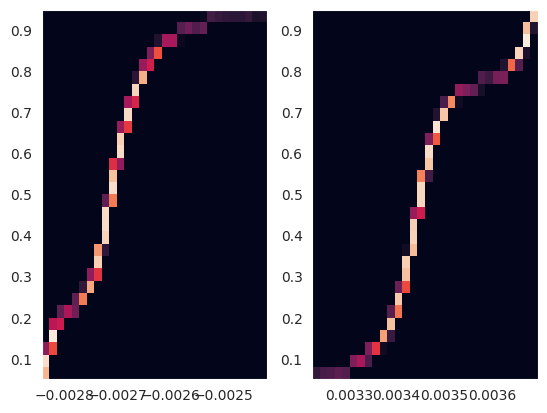

In [39]:
fig, axes = plt.subplots(1, 2)
_ = axes[0].hist2d(pts[restriction, 0], pts_uniform[restriction, 0], bins=30)
_ = axes[1].hist2d(pts[restriction, 1], pts_uniform[restriction, 1], bins=30)

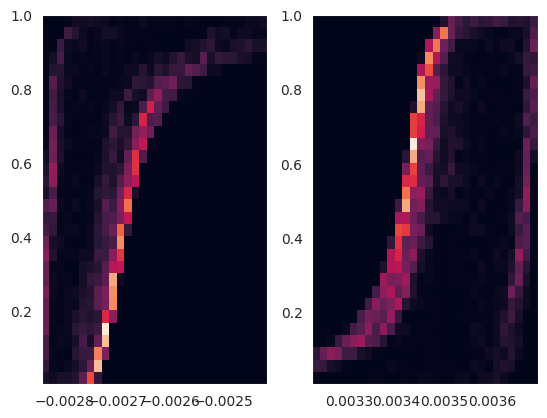

In [40]:
fig, axes = plt.subplots(1, 2)
_ = axes[0].hist2d(pts[restriction, 0], pts_cube[restriction, 0], bins=30)
_ = axes[1].hist2d(pts[restriction, 1], pts_cube[restriction, 1], bins=30)

(array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
           1.,   2.,   5.,   5.,  10.,  28., 234., 143.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   1.,   2.,   0.,
           2.,   2.,   9.,  23.,  76., 161.,  97.,  35.],
        [  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   1.,   0.,   0.,   2.,   1.,   1.,   1.,   0.,   1.,   5.,
           9.,   6.,  16.,  25.,  26.,  18.,  26.,   9.],
        [  1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
           1.,   0.,   0.,   0.,   2.,   2.,   0.,   0.,   2.,   2.,  12.,
          12.,   4.,   9.,   5.,   6.,   4.,  10.,  10.],
        [  1.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
           0.,   0.,   1.,   1.,   1.,   3.,   1.,  10.,  18.,  19.,   7.,
          12.,   0

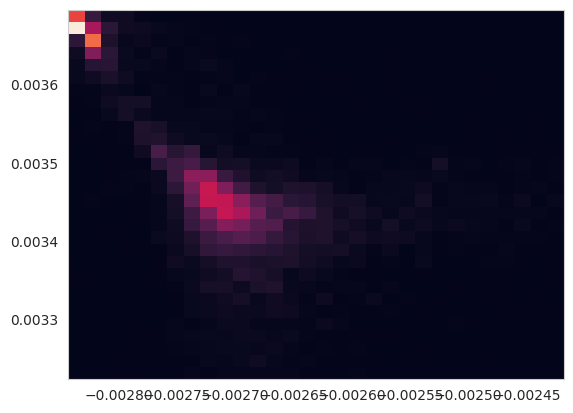

In [117]:
plt.hist2d(pts[foo, 0], pts[foo, 1], bins=30)

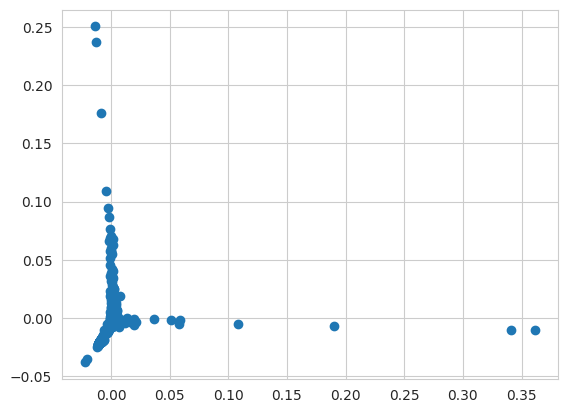

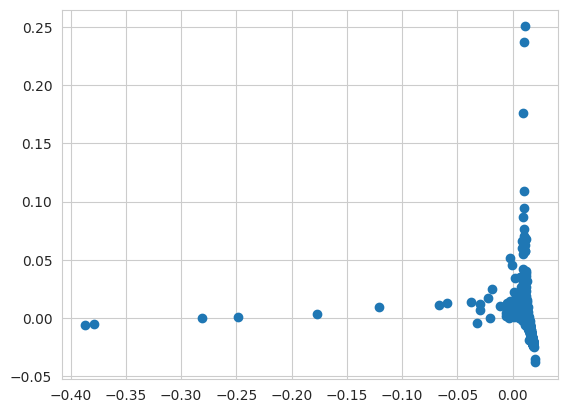

In [68]:
a, B, pts = utils.get_diffmap_and_points(g, process=None, ds=3)

plt.figure()
plt.scatter(pts[:, 2], pts[:, 1])

plt.figure()
plt.scatter(pts[:, 0], pts[:, 1])

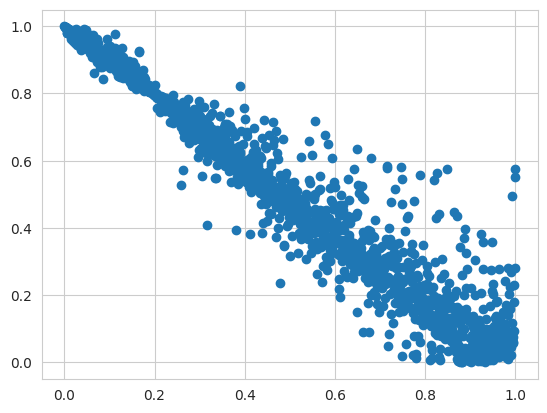

In [101]:
a, B, pts = utils.get_diffmap_and_points(g, process='uniformify')

plt.figure()
plt.scatter(pts[:, 0], pts[:, 1])

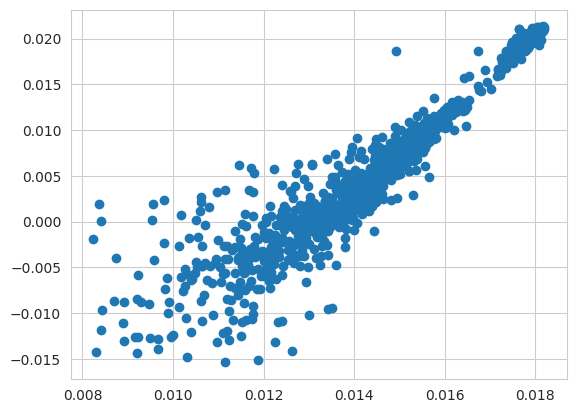

In [93]:
theta = 0.05
p1, p2 = np.quantile(pts[:, 0], (theta, 1-theta))
q1, q2 = np.quantile(pts[:, 1], (theta, 1-theta))
foo = pts[:, 0] > p1
foo &= pts[:, 0] < p2
foo &= pts[:, 1] > q1
foo &= pts[:, 1] < q2

plt.figure()
plt.scatter(pts[foo, 0], pts[foo, 1])

In [94]:
pts2 = pts.copy()

In [96]:
pts = pts2.copy()

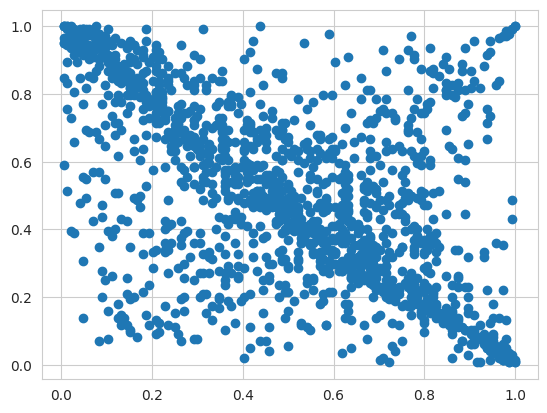

In [97]:
ds = 2
outputs = []
for k in range(0, ds):
    output = utils.cubify_dim(pts, k=k, perc_near=0.1)
    outputs.append(output)
pts = np.stack(outputs).T

plt.figure()
plt.scatter(pts[:, 0], pts[:, 1])

In [100]:
np.stack(outputs).shape

(2, 1446)

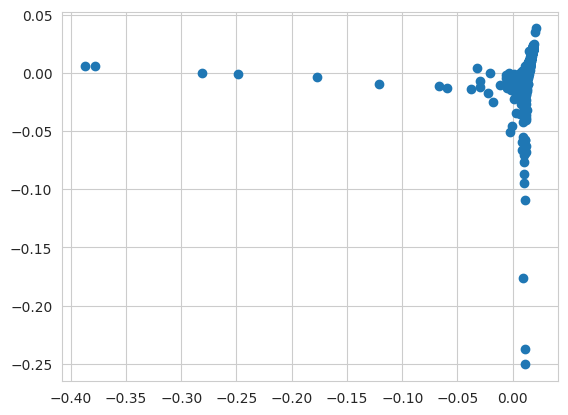

In [92]:
plt.figure()
plt.scatter(pts[:, 0], pts[:, 1])

(array([[23., 11.,  5.,  9.,  3.,  4.,  4.,  6.,  8., 34.],
        [11., 22., 13., 13., 15.,  7.,  6., 11., 17., 11.],
        [ 9., 12., 23., 22., 12., 10., 16., 27., 16.,  7.],
        [ 4.,  9., 19., 25., 28., 28., 31., 20., 17.,  8.],
        [ 4.,  8., 12., 16., 26., 31., 40., 21., 13.,  3.],
        [ 6.,  7.,  9., 20., 24., 30., 30., 23.,  5.,  6.],
        [ 4.,  5.,  8., 26., 26., 20., 25., 24.,  3.,  6.],
        [ 4.,  5., 26., 26., 15.,  5., 14., 17., 12.,  4.],
        [ 9., 23., 24., 18.,  7., 10., 11., 10., 14.,  4.],
        [50., 23., 11., 12.,  8.,  5.,  9.,  4.,  7.,  2.]]),
 array([0.00694444, 0.10625   , 0.20555556, 0.30486111, 0.40416667,
        0.50347222, 0.60277778, 0.70208333, 0.80138889, 0.90069444,
        1.        ]),
 array([0.00694444, 0.10625   , 0.20555556, 0.30486111, 0.40416667,
        0.50347222, 0.60277778, 0.70208333, 0.80138889, 0.90069444,
        1.        ]),
 <matplotlib.collections.QuadMesh at 0x2aca1c97c430>)

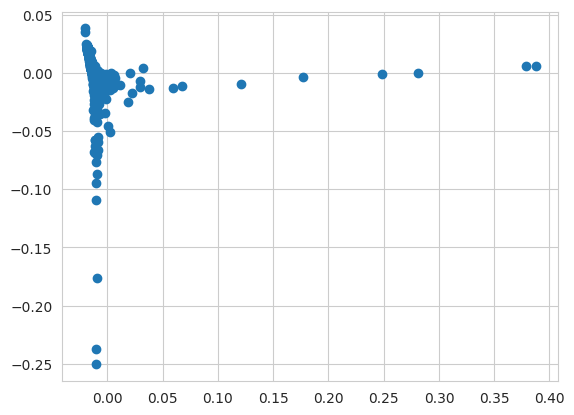

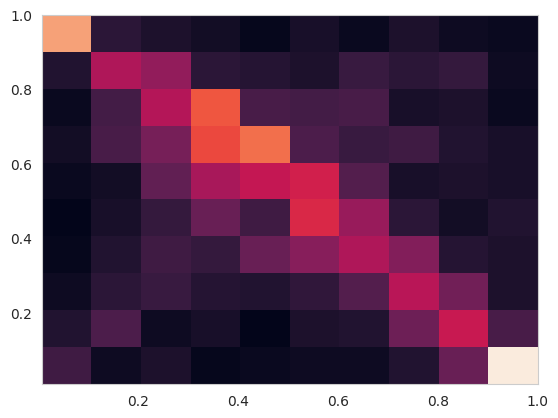

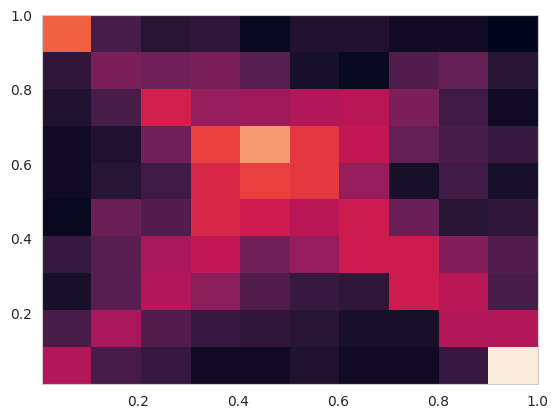

In [103]:
a, B, pts = utils.get_diffmap_and_points(g, process=None)

plt.figure()
plt.scatter(pts[:, 0], pts[:, 1])

a, B, pts = utils.get_diffmap_and_points(g,  process='cubify')

plt.figure()
plt.hist2d(pts[:, 0], pts[:, 1])

a, B, pts = utils.get_diffmap_and_points(g,  ds=3, process='cubify')

plt.figure()
plt.hist2d(pts[:, 0], pts[:, 1])

In [84]:
pts.shape

(2892,)

In [78]:
a, B, pts = utils.get_diffmap_and_points(g, process=None, ds=4)
pts.shape

(1446, 4)

In [79]:
outputs = [utils.cubify_dim(pts, k=k) for k in [1, 2, 3]]
np.stack(outputs, axis=-1).shape

(1446, 3)

In [80]:
pts[:, 1:] = np.stack(outputs, axis=-1)

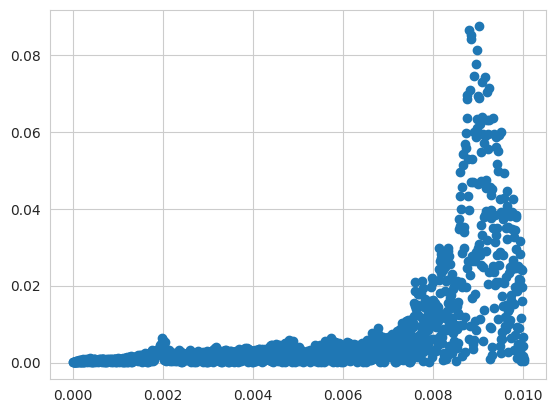

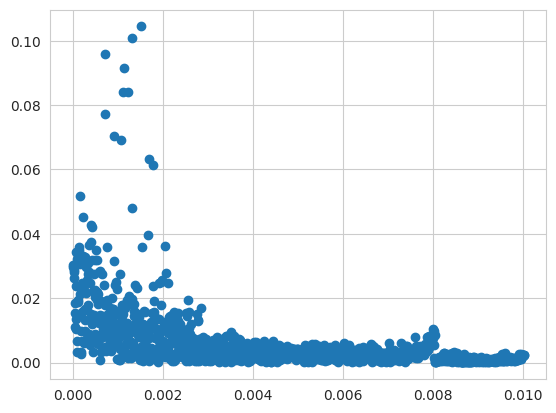

In [65]:
a, B, pts = utils.get_diffmap_and_points(g,  process='cuboidify', ds=2)

plt.figure()
plt.scatter(pts[:, 0], pts[:, 1])

a, B, pts = utils.get_diffmap_and_points(g,  process='cuboidify', ds=3)

plt.figure()
plt.scatter(pts[:, 0], pts[:, 1])

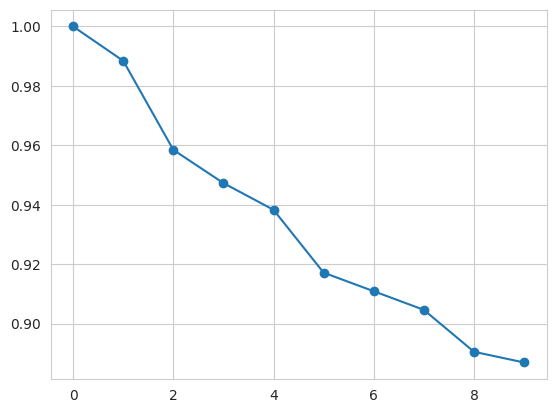

In [56]:
plt.plot(a, marker='o')

In [36]:
n = pts.shape[0]
k = 2
perc_near = 0.05
from sklearn.neighbors import KDTree
pts_without_k = np.concatenate([pts[:, 0:k], pts[:, k+1:]], axis=-1)
pts_kdtree = KDTree(pts_without_k)
output = []

# This is a crude filter - we only look at the 5% nearest points. We hope that the smoothness
# of the map is roughly ok in this range
num_near = int(pts.shape[0] * perc_near)

In [37]:
quantile=0.05
for u in range(n):
    distances, indices = pts_kdtree.query(pts_without_k[u:u+1], k=num_near)
    second_dim = pts[indices, k].squeeze()
    u_second_dim = pts[u, k]
    scale = 1.0 if not quantile else np.quantile(second_dim, 1 - quantile) - np.quantile(second_dim, quantile)
    output.append(scale * scipy.stats.percentileofscore(second_dim, u_second_dim)/100)

(array([528., 362., 247., 173.,  62.,  28.,  22.,  12.,   7.,   5.]),
 array([8.97347455e-06, 6.85453084e-04, 1.36193269e-03, 2.03841230e-03,
        2.71489191e-03, 3.39137152e-03, 4.06785113e-03, 4.74433074e-03,
        5.42081035e-03, 6.09728996e-03, 6.77376957e-03]),
 <BarContainer object of 10 artists>)

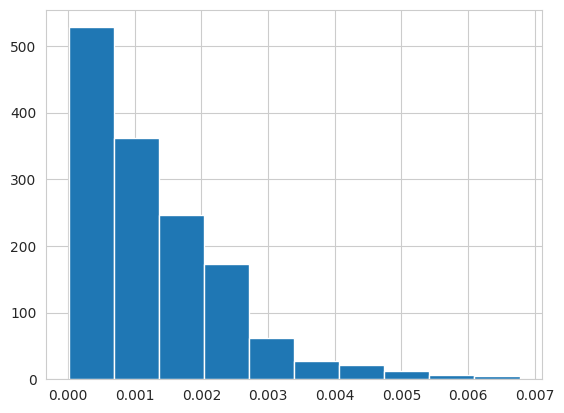

In [38]:
plt.hist(output)

../benji_girgs/generation.py:125: RuntimeWarning: divide by zero encountered in true_divide
  p_uv = np.divide(outer, dists**d)


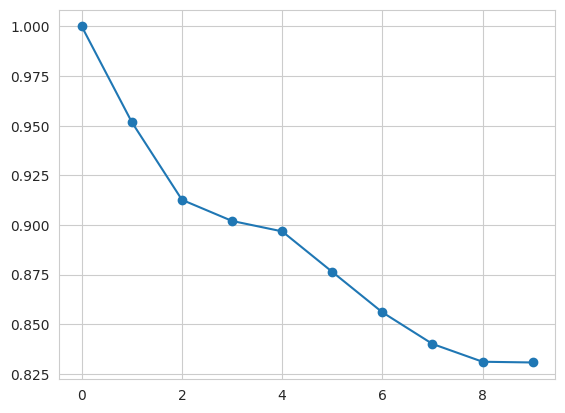

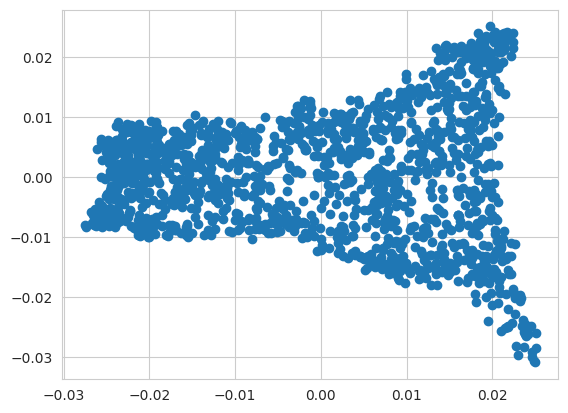

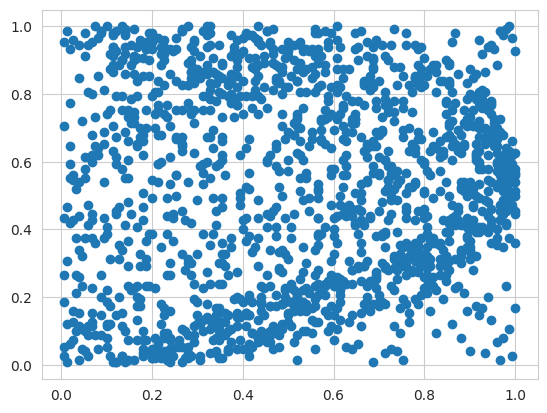

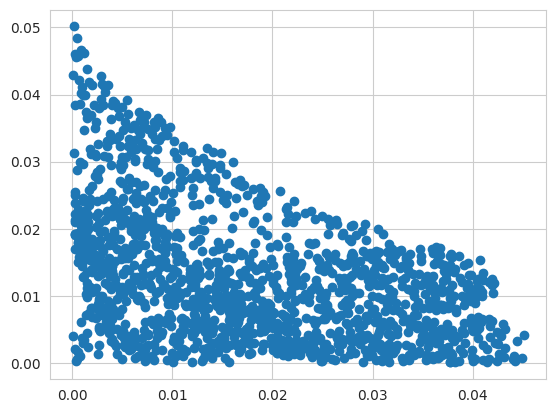

In [114]:
n = 1500
d=2
tau=2.1
alpha=1.2
desiredAvgDegree=100.0

pp = points.get_points_distorted(np.array([1.7, 1.0]), cube=True)

g, edges, weights, pts, const = generation.generate_GIRG_nk(n, d, tau, alpha, desiredAvgDegree=desiredAvgDegree, points_type=pp)

g = utils.get_largest_component(g)

a, B, pts = utils.get_diffmap_and_points(g, ds=2, process=None)
plt.figure()
plt.plot(a, marker='o')

plt.figure()
plt.scatter(pts[:, 0], pts[:, 1])

a, B, pts = utils.get_diffmap_and_points(g, ds=2, process='cubify')

plt.figure()
plt.scatter(pts[:, 0], pts[:, 1])

a, B, pts = utils.get_diffmap_and_points(g, ds=2, process='cuboidify')

plt.figure()
plt.scatter(pts[:, 0], pts[:, 1])

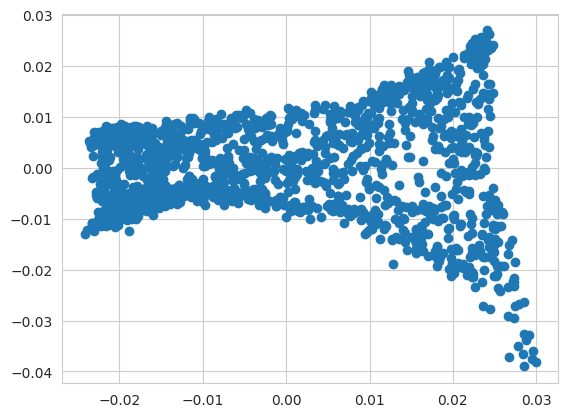

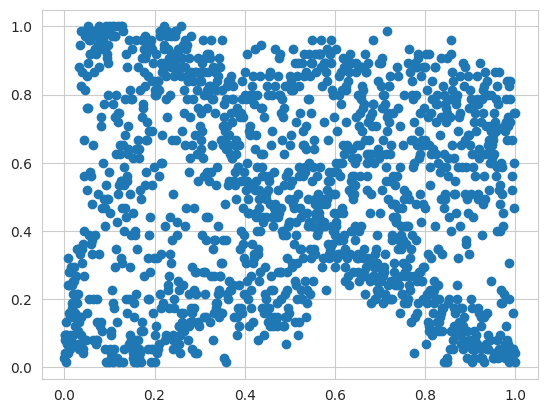

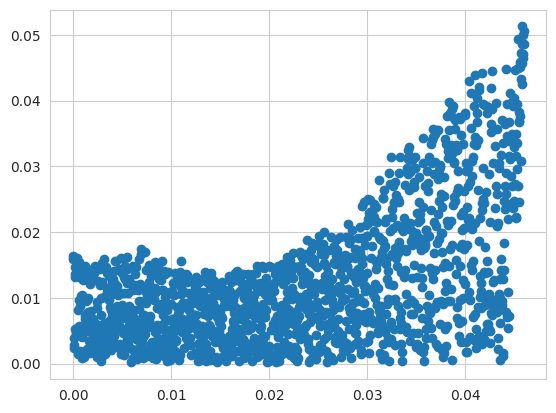

In [48]:
a, B, pts = utils.get_diffmap_and_points(g, ds=3, process=None)

plt.figure()
plt.scatter(pts[:, 0], pts[:, 1])

a, B, pts = utils.get_diffmap_and_points(g, ds=3, process='cubify')

plt.figure()
plt.scatter(pts[:, 0], pts[:, 1])

a, B, pts = utils.get_diffmap_and_points(g, ds=3, process='cuboidify')

plt.figure()
plt.scatter(pts[:, 0], pts[:, 1])

In [17]:
ex = np.arange(24).reshape(4, 6)
x

array([[ 0,  1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10, 11],
       [12, 13, 14, 15, 16, 17],
       [18, 19, 20, 21, 22, 23]])

In [18]:
np.concatenate([x[1:2, 0:1], x[1:2, 2:]], axis=-1)

array([[ 6,  8,  9, 10, 11]])

In [52]:
print(np.std(pts[:, 0]))
print(np.std(pts[:, 1]))

0.019732578560525977
0.016790433265577782


In [53]:
p = np.quantile(pts[:, 0], 0.1)
q = np.quantile(pts[:, 0], 0.9)
print(p, q, q-p)

p = np.quantile(pts[:, 1], 0.1)
q = np.quantile(pts[:, 1], 0.9)
print(p, q, q-p)

-0.018049727996720614 -0.010394604212795987 0.007655123783924626
-0.02065280899819591 0.008512103527265532 0.02916491252546144


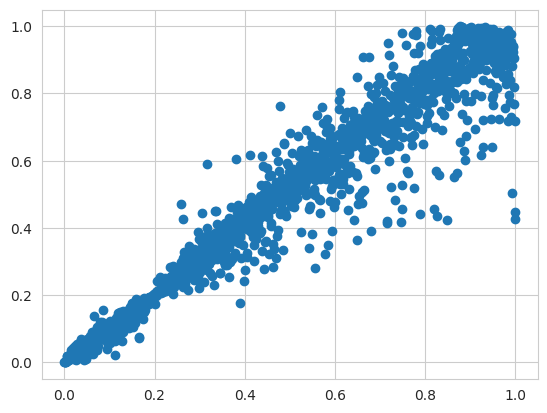

In [54]:
a, B, pts = utils.get_diffmap_and_points(g, process='uniformify')

plt.figure()
plt.scatter(pts[:, 0], pts[:, 1])

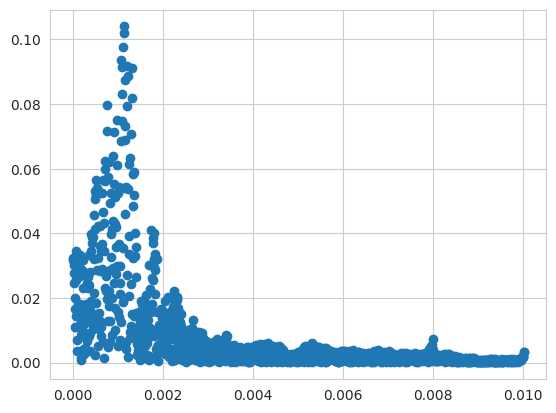

In [55]:
a, B, pts = utils.get_diffmap_and_points(g, process='cuboidify')

plt.figure()
plt.scatter(pts[:, 0], pts[:, 1])
# plt.figure()
# # plt.hist2d(pts[:, 0], pts_girg[:, 0], bins=30)
# plt.figure()
# plt.hist2d(pts[:, 1], pts_girg[:, 1], bins=30)
# print(np.corrcoef(pts[:, 0], pts_girg[:, 0]))
# print(np.corrcoef(pts[:, 1], pts_girg[:, 1]))

In [10]:
list(range(1, 0, -1))

[1]

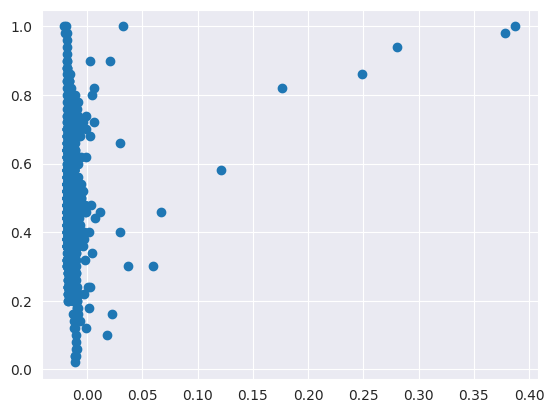

In [131]:
_, _, pts = utils.get_diffmap_and_points(g, process=None)
output = utils.cubify_last_k_dim(pts, k=2, num_near=50)
pts[:, 1] = output
plt.scatter(pts[:, 0], pts[:, 1])

In [126]:
list(range(2, 1, -1))

[2]

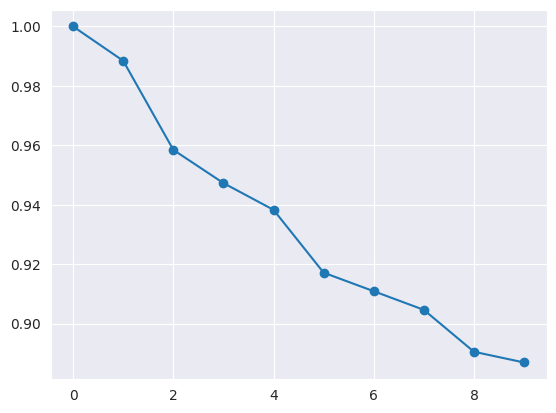

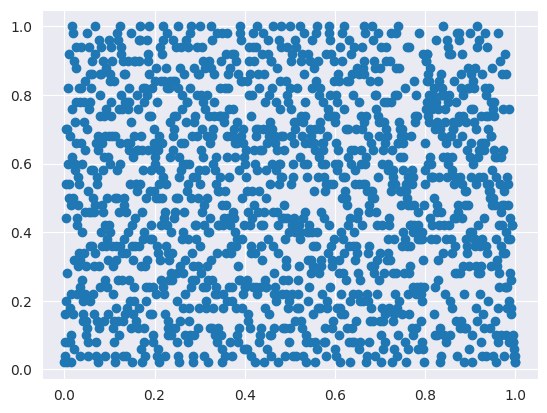

PointsCube([[0.17704011, 0.4       ],
            [0.1659751 , 0.96      ],
            [0.71991701, 0.44      ],
            ...,
            [0.02973721, 0.48      ],
            [0.57952974, 0.04      ],
            [0.23582296, 0.4       ]])

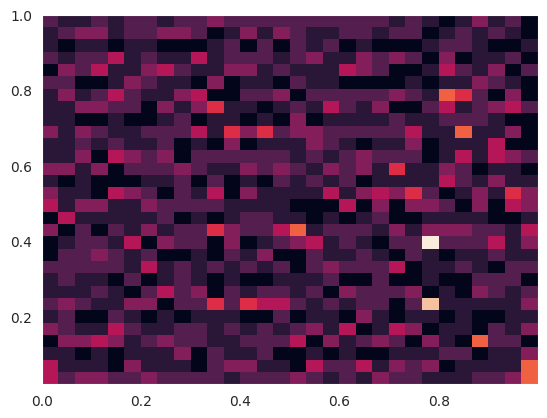

<Figure size 640x480 with 0 Axes>

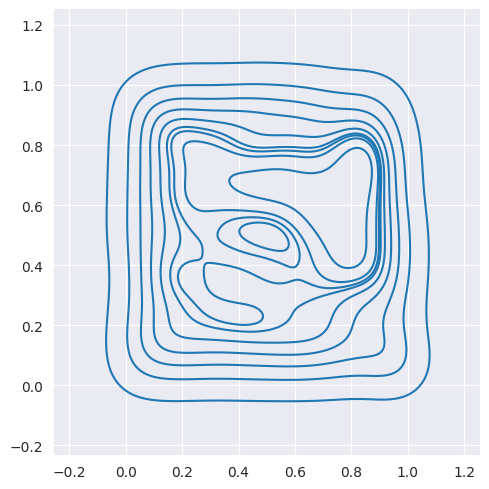

In [98]:
mcmc.quick_2dhistplot(g, process='cubify')

'/cluster/scratch/bdayan/GIRG_data/socfb-Amherst41.SpaceOne'

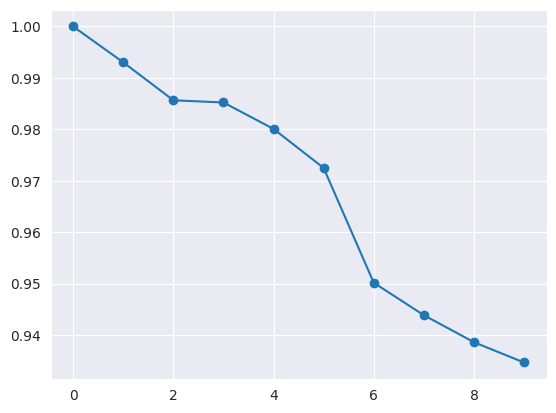

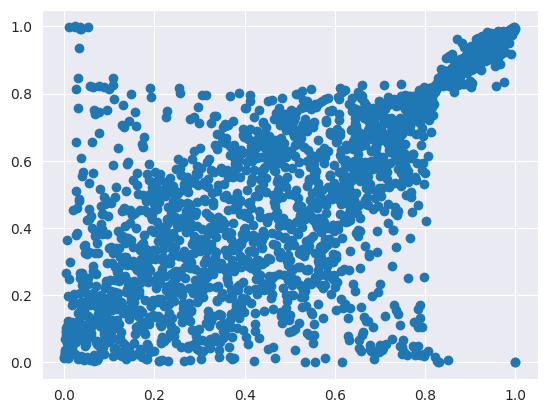

PointsCube([[0.52751678, 0.701566  ],
            [0.44966443, 0.64205817],
            [0.60850112, 0.7852349 ],
            ...,
            [0.07024609, 0.16957494],
            [0.33691275, 0.0639821 ],
            [0.93780761, 0.98165548]])

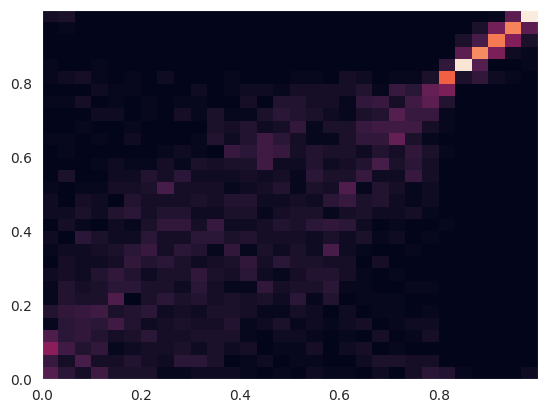

<Figure size 640x480 with 0 Axes>

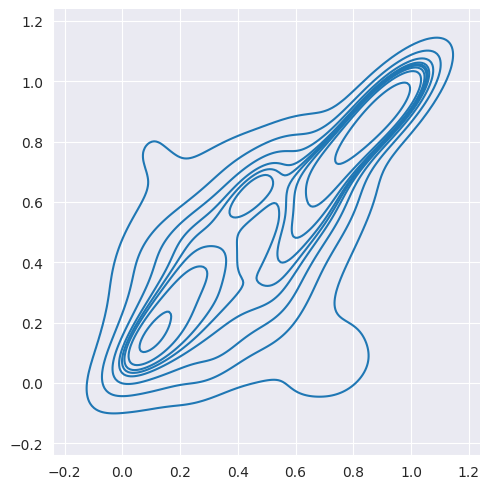

In [64]:
gd = list(filter(lambda x: x['Name'] == 'socfb-Amherst41', do_feature_extract.graph_dicts))[0]
in_path = gd['FullPath']
in_path
name = gd['Name']
g = networkit.readGraph(in_path, networkit.Format.EdgeListSpaceOne)
g = utils.get_largest_component(g)
# nk.overview(g)
n = g.numberOfNodes()


mcmc.quick_2dhistplot(g, process='uniformify')

'/cluster/scratch/bdayan/GIRG_data/socfb-Simmons81.SpaceOne'

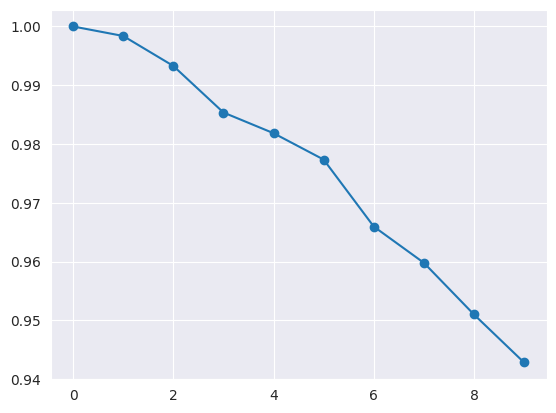

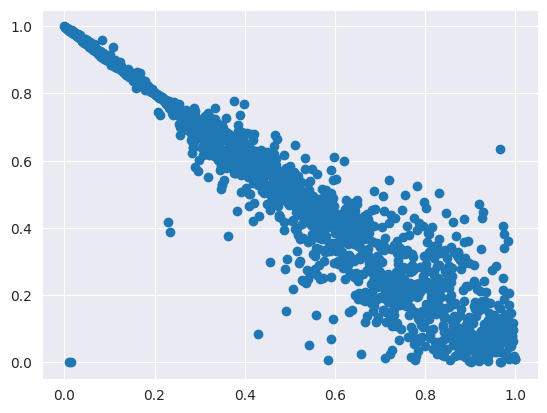

PointsCube([[0.51324503, 0.44900662],
            [0.8794702 , 0.15827815],
            [0.93708609, 0.01589404],
            ...,
            [0.94701987, 0.08410596],
            [0.60463576, 0.35298013],
            [0.7602649 , 0.40662252]])

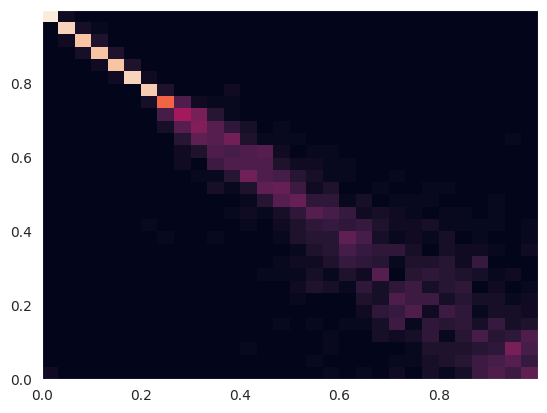

<Figure size 640x480 with 0 Axes>

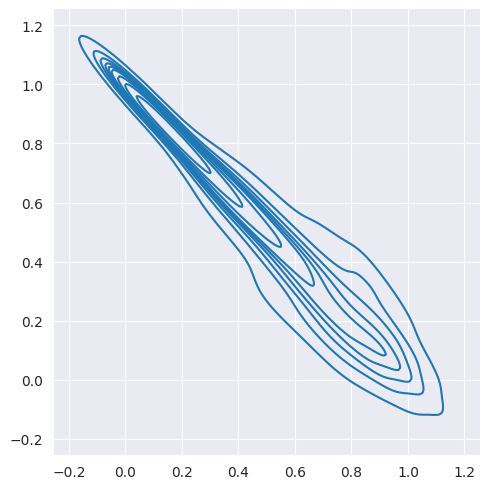

In [65]:
gd = list(filter(lambda x: x['Name'] == 'socfb-Simmons81', do_feature_extract.graph_dicts))[0]
in_path = gd['FullPath']
in_path
name = gd['Name']
g = networkit.readGraph(in_path, networkit.Format.EdgeListSpaceOne)
g = utils.get_largest_component(g)
# nk.overview(g)
n = g.numberOfNodes()


mcmc.quick_2dhistplot(g, process='uniformify')

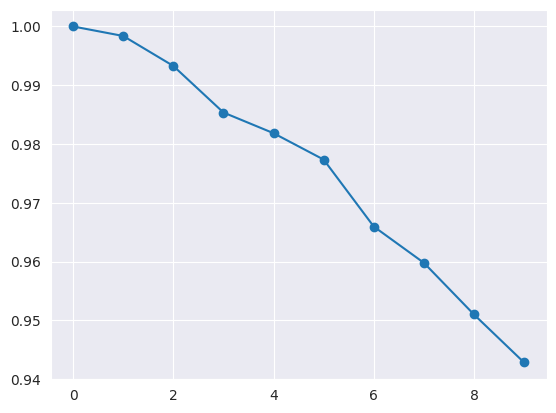

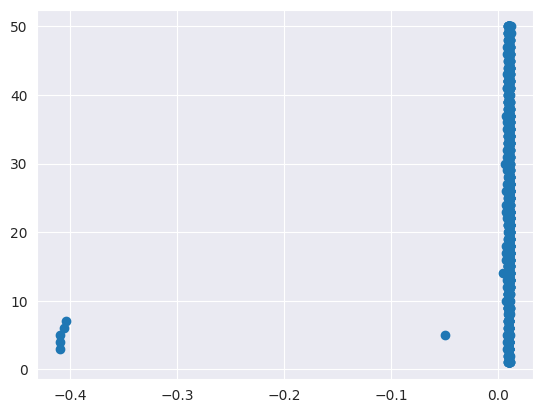

PointsCube([[1.01044864e-02, 1.90000000e+01],
            [9.71650360e-03, 3.00000000e+01],
            [9.47356947e-03, 4.00000000e+00],
            ...,
            [9.39975529e-03, 2.60000000e+01],
            [1.00400773e-02, 1.80000000e+01],
            [9.90374992e-03, 4.70000000e+01]])

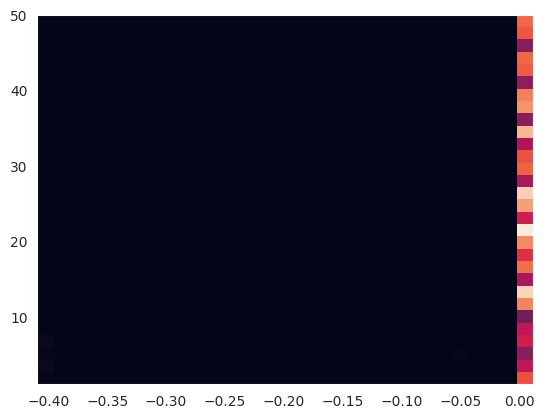

<Figure size 640x480 with 0 Axes>

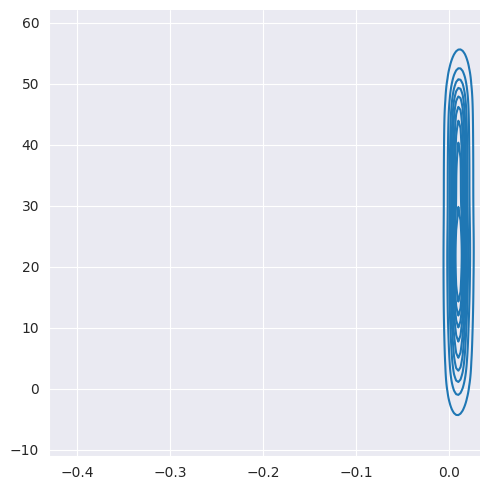

In [66]:
mcmc.quick_2dhistplot(g, process='cubify')

<Figure size 640x480 with 0 Axes>

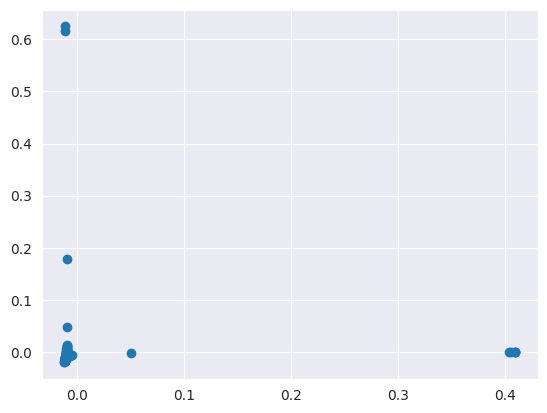

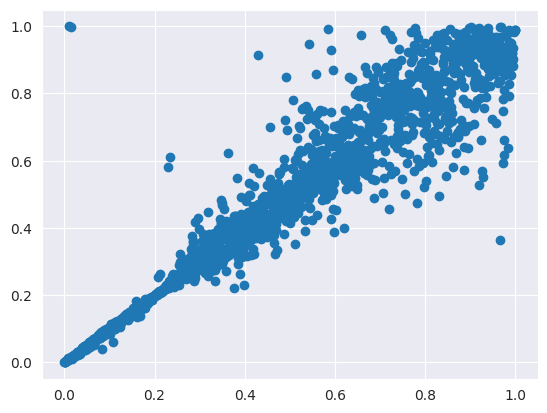

In [70]:
w, Phi, Psi, diff_map = utils.get_diffmap(g, Iweighting=0.5, eye_or_ones='eye')
d=2
pts_diffmap = np.array([diff_map(i, 4) for i in range(n)])[:, 0:d]
plt.scatter(pts_diffmap[:, 0], pts_diffmap[:, 1])
pts_diffmap2 = utils.uniformify_pts(pts_diffmap)
plt.figure()
plt.scatter(pts_diffmap2[:, 0], pts_diffmap2[:, 1])

<Figure size 640x480 with 0 Axes>

(array([[  2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   3.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   3.,   1.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   1.,  16.,   7.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0., 235.,  24.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0

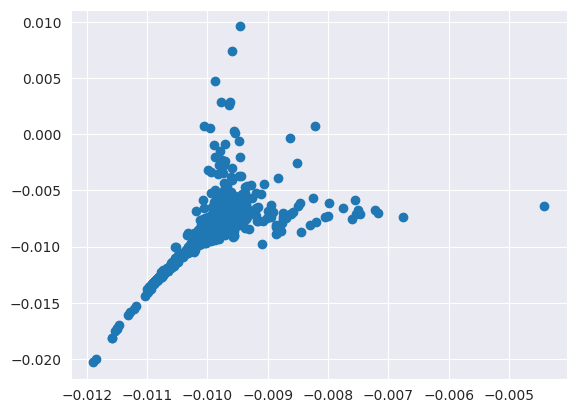

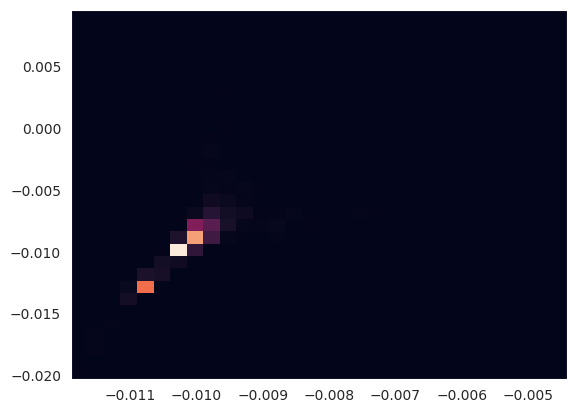

In [76]:
a, b = pts_diffmap[:, 0], pts_diffmap[:, 1]
foo = -0.04 < a
foo = foo & (a < 0.0)
foo = foo & (-0.03 < b)
foo = foo & (b < 0.01)
plt.scatter(a[foo], b[foo])
plt.figure()
plt.hist2d(a[foo], b[foo], bins=30)

In [89]:
from sklearn.neighbors import KDTree
import scipy.stats

pts = pts_diffmap
n = pts.shape[0]
pts_kdtree = KDTree(pts[:, 0:1])

u = 0
pts[u]
distances, indices = pts_kdtree.query(pts[0:1, 0:1], k=50)
second_dim = pts[indices, 1].squeeze()
u_second_dim = pts[u, 1]
u_second_dim
second_dim
scipy.stats.percentileofscore(second_dim, u_second_dim)/100

array([-0.01010449, -0.00903392])

-0.009033923216852612

array([-0.00903392, -0.00884941, -0.00908485, -0.00862279, -0.00902163,
       -0.00886375, -0.00937746, -0.00941791, -0.00885154, -0.00880238,
       -0.0097885 , -0.009509  , -0.00920545, -0.00954014, -0.00921941,
       -0.00929722, -0.00898352, -0.00848891, -0.00935384, -0.00851039,
       -0.00876044, -0.00944368, -0.00960446, -0.00922664, -0.00919223,
       -0.00913791, -0.00924157, -0.00808599, -0.00894328, -0.00918419,
       -0.00954764, -0.00945255, -0.00918523, -0.00893515, -0.00901025,
       -0.00923886, -0.00935833, -0.00823678, -0.00888879, -0.00937915,
       -0.00820675, -0.00921489, -0.00964035, -0.00924222, -0.0087695 ,
       -0.00923627, -0.0093047 , -0.00909802, -0.00947361, -0.00930447])

0.64

In [94]:
import importlib
importlib.reload(mcmc)
n = pts_diffmap.shape[0]

pts_temp = pts_diffmap.copy()
pts_temp[:, 1] = mcmc.cubify_last_k_dim(pts_temp, k=1)
# pts_temp[:, 0] = pts_temp[:, 0].argsort().argsort() / n

<module 'benji_girgs.mcmc' from '../benji_girgs/mcmc.py'>

(array([[137., 140., 153., 158., 165., 190., 165., 172., 105., 119.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   3.]]),
 array([-0.01189222,  0.03022586,  0.07234394,  0.11446202,  0.1565801 ,
         0.19869818,  0.24081626,  0.28293434,  0.32505242,  0.3671705 ,
         0.40928858]),
 array([0.02 , 0.118, 0.216, 0.314, 0.412, 0.51 , 0.608, 0.706, 0.804,
        0.902, 1.   ]),
 <matplotlib.collections.QuadMesh 

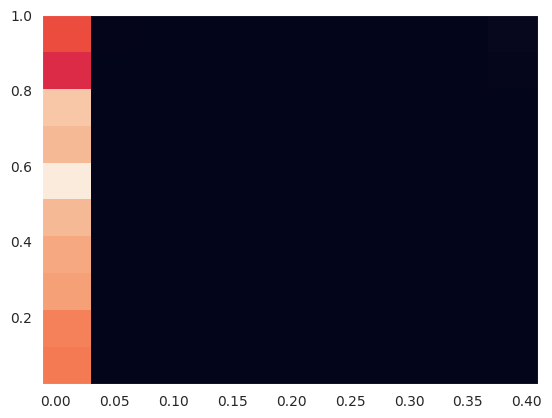

In [95]:
plt.hist2d(pts_temp[:, 0], pts_temp[:, 1])

In [45]:
# gd = list(filter(lambda x: x['Name'] == 'socfb-Haverford76', do_feature_extract.graph_dicts))[0]
# in_path = gd['FullPath']
# in_path
# name = gd['Name']
# g = networkit.readGraph(in_path, networkit.Format.EdgeListSpaceOne)
# g = utils.get_largest_component(g)
# nk.overview(g)
# n = g.numberOfNodes()


n = 4000
d=2
tau=2.1
alpha=1.2
desiredAvgDegree=100.0
pp = points.get_points_distorted(np.array([2.0, 1.0]), cube=True)
# pp = points.PointsCube
g, edges, weights, pts_girg, const = generation.generate_GIRG_nk(n, d, tau, alpha, desiredAvgDegree=desiredAvgDegree, points_type=pp)
g = utils.get_largest_component(g)
# nk.overview(g)
n = g.numberOfNodes()
#
# a, B, pts = utils.get_diffmap_and_points(g, process=None)
# plt.scatter(pts[:, 0], pts[:, 1])
#
# plt.figure()
# a, B, pts = utils.get_diffmap_and_points(g, process='put_in_cube')
# plt.scatter(pts[:, 0], pts[:, 1])
#
# plt.figure()
# a, B, pts = utils.get_diffmap_and_points(g, process='uniformify')
# plt.scatter(pts[:, 0], pts[:, 1])
#
# plt.figure()
# a, B, pts = utils.get_diffmap_and_points(g, process='cubify')
# plt.scatter(pts[:, 0], pts[:, 1])

../benji_girgs/generation.py:125: RuntimeWarning: divide by zero encountered in true_divide
  p_uv = np.divide(outer, dists**d)


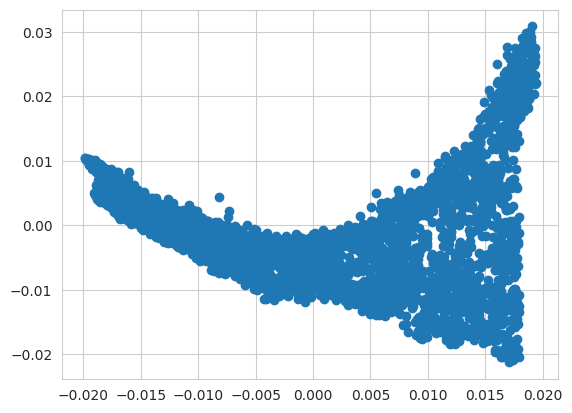

In [47]:
plt.figure()
a, B, pts = utils.get_diffmap_and_points(g, process=None)
plt.scatter(pts[:, 0], pts[:, 1])

[[ 1.         -0.99506875]
 [-0.99506875  1.        ]]
[[ 1.         -0.48198439]
 [-0.48198439  1.        ]]


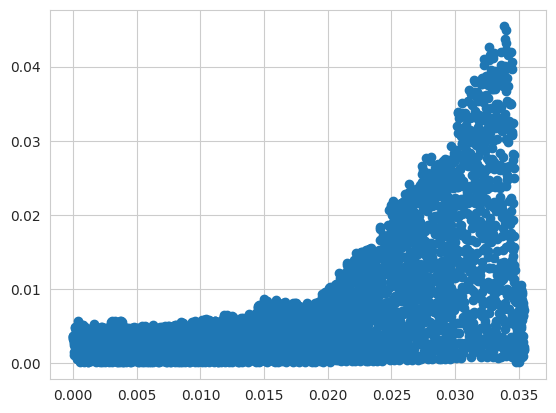

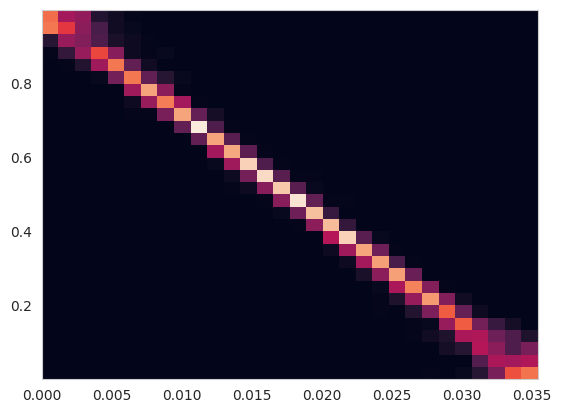

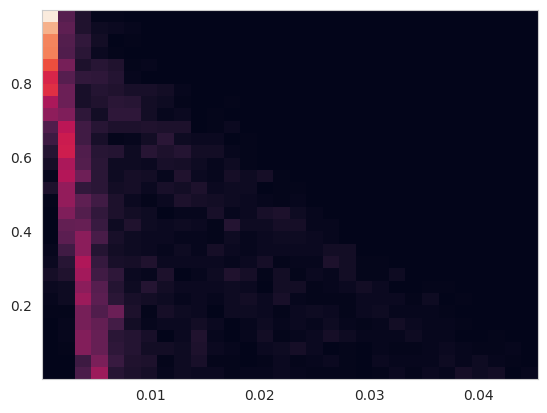

In [46]:
a, B, pts = utils.get_diffmap_and_points(g, process='cuboidify')

plt.figure()
plt.scatter(pts[:, 0], pts[:, 1])
plt.figure()
plt.hist2d(pts[:, 0], pts_girg[:, 0], bins=30)
plt.figure()
plt.hist2d(pts[:, 1], pts_girg[:, 1], bins=30)
print(np.corrcoef(pts[:, 0], pts_girg[:, 0]))
print(np.corrcoef(pts[:, 1], pts_girg[:, 1]))

[[ 1.         -0.99449675]
 [-0.99449675  1.        ]]
[[1.        0.7240495]
 [0.7240495 1.       ]]


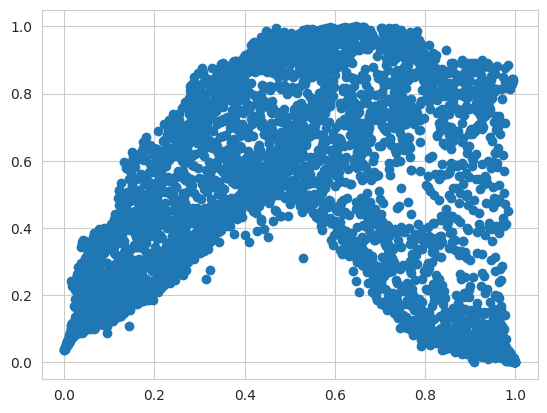

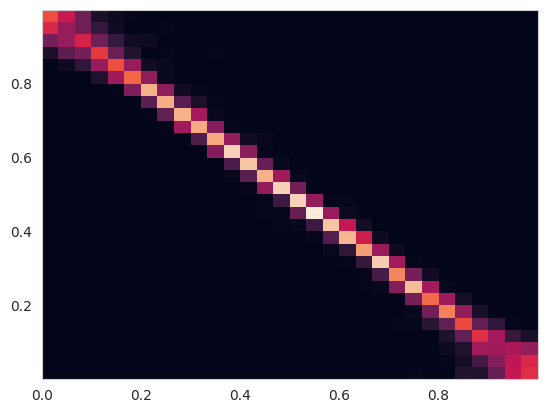

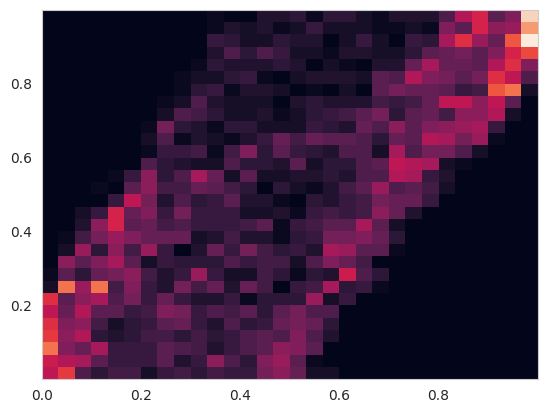

In [30]:
a, B, pts = utils.get_diffmap_and_points(g, process='uniformify')

plt.figure()
plt.scatter(pts[:, 0], pts[:, 1])
plt.figure()
plt.hist2d(pts[:, 0], pts_girg[:, 0], bins=30)
plt.figure()
plt.hist2d(pts[:, 1], pts_girg[:, 1], bins=30)

print(np.corrcoef(pts[:, 0], pts_girg[:, 0]))
print(np.corrcoef(pts[:, 1], pts_girg[:, 1]))

In [117]:
np.array([1,2,3,34.3]).size

4

In [112]:
pts_diffmap = np.array([diff_map(i, 4) for i in range(n)])[:, 0:2]

pts_diffmap[:, 1] = mcmc.cubify_last_k_dim(pts_diffmap, k=1, num_near=50)
pts_diffmap[:, 0] = pts_diffmap[:, 0].argsort().argsort()/n

pts_diffmap2 = np.array([diff_map(i, 4) for i in range(n)])[:, 0:2]

np.corrcoef(pts_diffmap[:, 0], pts[:, 1])
np.corrcoef(pts_diffmap[:, 1], pts[:, 0])
np.corrcoef(pts_diffmap2[:, 0], pts[:, 1])
np.corrcoef(pts_diffmap2[:, 1], pts[:, 0])


array([[ 1.        , -0.91680178],
       [-0.91680178,  1.        ]])

array([[1.        , 0.75542493],
       [0.75542493, 1.        ]])

array([[ 1.        , -0.89576311],
       [-0.89576311,  1.        ]])

array([[1.        , 0.87674292],
       [0.87674292, 1.        ]])

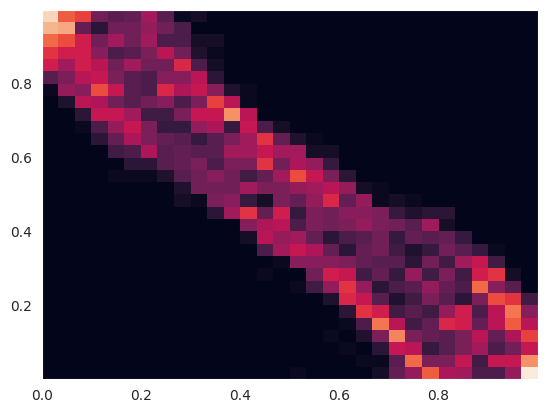

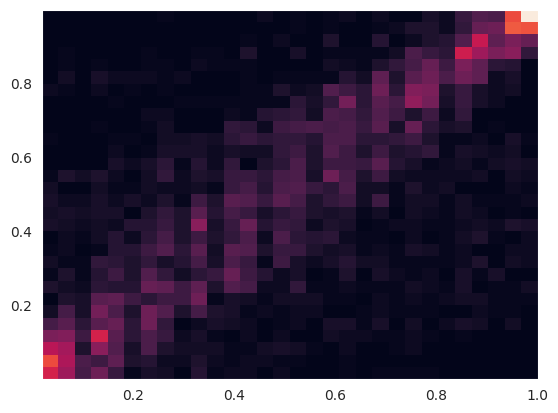

In [111]:
_ = plt.hist2d(pts_diffmap[:, 0], pts[:,1], bins=30)
_ = plt.figure()
_ = plt.hist2d(pts_diffmap[:, 1], pts[:, 0], bins=30)

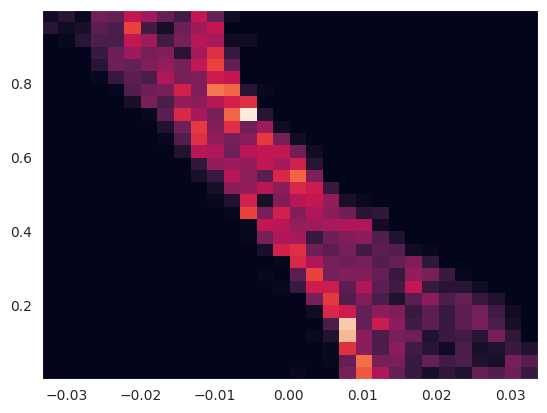

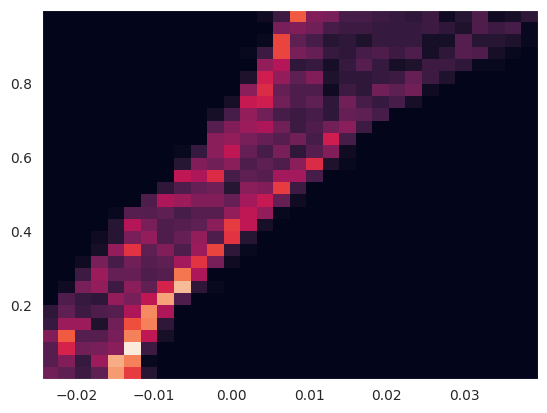

In [109]:
_ = plt.hist2d(pts_diffmap[:, 0], pts[:,1], bins=30)
_ = plt.figure()
_ = plt.hist2d(pts_diffmap[:, 1], pts[:, 0], bins=30)

In [13]:
n = g.numberOfNodes()
d=2
w, Phi, Psi, diff_map = utils.get_diffmap(g, Iweighting=0.5, eye_or_ones='eye')

pts_diffmap = np.array([diff_map(i, 10) for i in range(n)])[:, 0:2]


array([1.        , 0.99676645, 0.9963275 , 0.99600359, 0.99448918,
       0.99399544, 0.99394449, 0.99386548, 0.99356173, 0.99079725])

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

(array([6.000e+00, 4.000e+00, 2.000e+00, 3.000e+00, 6.000e+00, 4.000e+00,
        5.000e+00, 6.000e+00, 1.000e+01, 2.800e+01, 1.080e+02, 1.187e+03,
        5.220e+02, 2.603e+03, 1.176e+03, 2.970e+02, 6.300e+01, 3.400e+01,
        1.600e+01, 1.100e+01, 1.100e+01, 1.200e+01, 9.000e+00, 5.000e+00,
        1.100e+01, 1.000e+01, 9.000e+00, 7.000e+00, 6.000e+00, 4.000e+00]),
 array([-3.98318998e-03, -3.85162114e-03, -3.72005230e-03, -3.58848346e-03,
        -3.45691462e-03, -3.32534578e-03, -3.19377694e-03, -3.06220810e-03,
        -2.93063926e-03, -2.79907042e-03, -2.66750158e-03, -2.53593274e-03,
        -2.40436390e-03, -2.27279505e-03, -2.14122621e-03, -2.00965737e-03,
        -1.87808853e-03, -1.74651969e-03, -1.61495085e-03, -1.48338201e-03,
        -1.35181317e-03, -1.22024433e-03, -1.08867549e-03, -9.57106647e-04,
        -8.25537807e-04, -6.93968966e-04, -5.62400125e-04, -4.30831284e-04,
        -2.99262444e-04, -1.67693603e-04, -3.61247622e-05]),
 <BarContainer object of 30 artists

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 2.000e+00, 4.000e+00, 7.000e+00, 3.000e+00, 1.000e+00,
        1.400e+01, 1.500e+01, 1.030e+02, 1.663e+03, 4.052e+03, 1.440e+02,
        5.100e+01, 2.800e+01, 3.400e+01, 1.400e+01, 8.000e+00, 7.000e+00,
        8.000e+00, 2.000e+00, 3.000e+00, 3.000e+00, 4.000e+00, 2.000e+00]),
 array([-0.00785727, -0.00753729, -0.00721731, -0.00689734, -0.00657736,
        -0.00625738, -0.0059374 , -0.00561742, -0.00529745, -0.00497747,
        -0.00465749, -0.00433751, -0.00401753, -0.00369756, -0.00337758,
        -0.0030576 , -0.00273762, -0.00241764, -0.00209767, -0.00177769,
        -0.00145771, -0.00113773, -0.00081775, -0.00049778, -0.0001778 ,
         0.00014218,  0.00046216,  0.00078214,  0.00110211,  0.00142209,
         0.00174207]),
 <BarContainer object of 30 artists>)

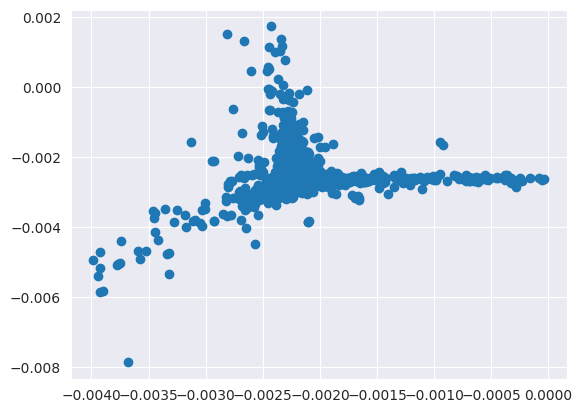

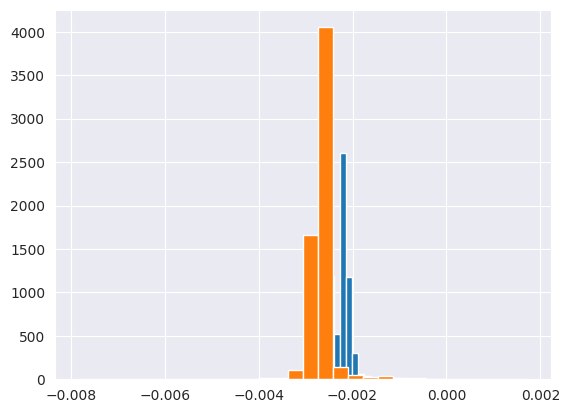

In [43]:
a = pts_diffmap[:, 0]
b = pts_diffmap[:, 1]
foo = -0.004 < a
foo = foo & (a < 0.0)
foo = foo & (-0.01 < b)
foo = foo & (b < 0.002)
# plt.hist2d(a[foo], b[foo], bins=30)

pts_diffmap_uniformed = utils.uniformify_pts(pts_diffmap)
plt.figure()
plt.scatter(a[foo], b[foo])
plt.figure()
# plt.hist2d(pts_diffmap_uniformed[foo, 0], pts_diffmap_uniformed[foo, 1], bins=30)
plt.hist(a[foo], bins=30)
# plt.figure()
plt.hist(b[foo], bins=30)

In [44]:
np.std(a[foo])
np.std(b[foo])

0.00026268944343803627

0.00035746215798278014

(array([[663., 620., 649., 642., 647., 636., 628., 629., 609., 644.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.]]),
 array([-0.02304776,  0.04598507,  0.1150179 ,  0.18405074,  0.25308357,
         0.32211641,  0.39114924,  0.46018207,  0.52921491,  0.59824774,
         0.66728057]),
 array([ 1. ,  5.9, 10.8, 15.7, 20.6, 25.5, 30.4, 35.3, 40.2, 45.1, 50. ]),
 <matplotlib.collections.QuadMesh at 0x2b322a031d60>)

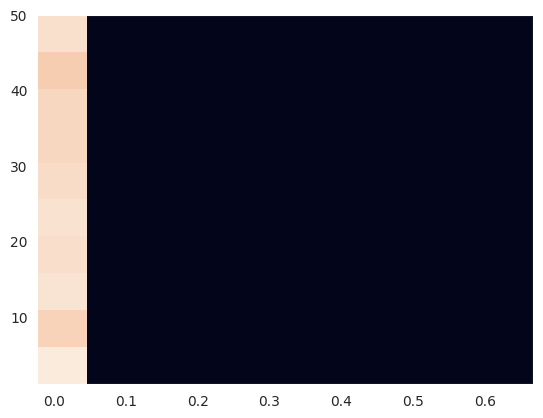

In [35]:
output = mcmc.cubify_last_k_dim(pts_diffmap, k=1)
pts_diffmap2 = pts_diffmap.copy()
pts_diffmap2[:, 1] = output
plt.hist2d(pts_diffmap2[:, 0], pts_diffmap2[:, 1])

(array([[54., 66., 61., 66., 71., 82., 61., 65., 55., 56.],
        [61., 64., 68., 63., 60., 66., 60., 68., 63., 64.],
        [62., 65., 62., 65., 57., 68., 71., 64., 61., 62.],
        [63., 62., 66., 62., 62., 63., 66., 67., 60., 66.],
        [69., 61., 68., 57., 66., 58., 71., 60., 58., 69.],
        [57., 66., 64., 74., 55., 70., 58., 72., 60., 61.],
        [64., 64., 62., 65., 61., 71., 57., 70., 60., 63.],
        [64., 60., 65., 69., 60., 64., 65., 61., 64., 65.],
        [68., 59., 60., 67., 63., 59., 67., 61., 63., 70.],
        [64., 61., 62., 65., 63., 65., 70., 53., 65., 69.]]),
 array([0.        , 0.0999843 , 0.1999686 , 0.2999529 , 0.39993721,
        0.49992151, 0.59990581, 0.69989011, 0.79987441, 0.89985871,
        0.99984301]),
 array([ 1. ,  5.9, 10.8, 15.7, 20.6, 25.5, 30.4, 35.3, 40.2, 45.1, 50. ]),
 <matplotlib.collections.QuadMesh at 0x2b32269fe490>)

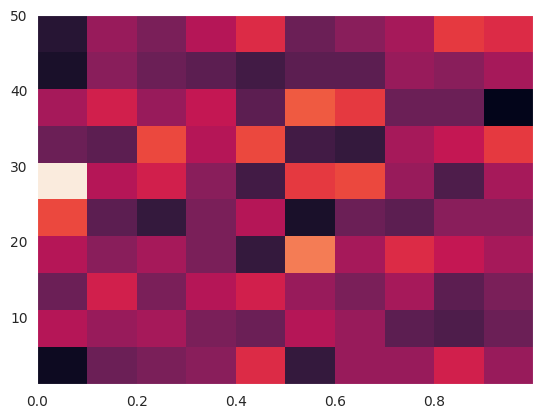

In [34]:
output = mcmc.cubify_last_k_dim(pts_diffmap_uniformed, k=1)
pts_diffmap_uniformed2 = pts_diffmap_uniformed.copy()
pts_diffmap_uniformed2[:, 1] = output
plt.hist2d(pts_diffmap_uniformed2[:, 0], pts_diffmap_uniformed2[:, 1])

In [8]:
df.loc[df.Model == '1d-copyweight-cube-girg'].sort_values('Nodes').loc[:, ['Graph', 'Model', 'Nodes', 'Info']]

Graph                    Model  Nodes  \
0       socfb-Caltech36  1d-copyweight-cube-girg    756   
1          socfb-Reed98  1d-copyweight-cube-girg    955   
4     socfb-Haverford76  1d-copyweight-cube-girg   1440   
3       socfb-Simmons81  1d-copyweight-cube-girg   1497   
6    socfb-Swarthmore42  1d-copyweight-cube-girg   1657   
..                  ...                      ...    ...   
162         socfb-MSU24  1d-copyweight-cube-girg  32345   
167            socfb-UF  1d-copyweight-cube-girg  35095   
165          socfb-UF21  1d-copyweight-cube-girg  35101   
117       socfb-Texas84  1d-copyweight-cube-girg  36354   
132        socfb-Penn94  1d-copyweight-cube-girg  41520   

                                                  Info  
0    {'tau': 7.3017225936374555, 'alpha': 1.2171928...  
1    {'tau': 4.381732472502371, 'alpha': 1.07671601...  
4    {'tau': 6.5461700448727616, 'alpha': 1.0592519...  
3    {'tau': 4.739342146243066, 'alpha': 1.16300199...  
6    {'tau': 5.598783007439967, 'alpha': 1.04234527...  
..                                                 ...  
162  {'tau': 5.112979295133962, 'alpha': 1.02195608...  
167  {'tau': 4.918454781144023, 'alpha': 1.05073058...  
165  {'tau': 4.918454781144023, 'alpha': 1.04652113...  
117  {'tau': 4.774843344808111, 'alpha': 1.01010101...  
132  {'tau': 4.159945099786496, 'alpha': 1.01010101...  

[94 rows x 4 columns]

'/cluster/scratch/bdayan/GIRG_data/socfb-Bucknell39.SpaceOne'

Network Properties:
nodes, edges			3824, 158863
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.021734
clustering coefficient		0.278605
min/max/avg degree		1, 506, 83.087343
degree assortativity		0.094494
number of connected components	1
size of largest component	3824 (100.00 %)


PointsCube([[0.42756276, 0.80726987],
            [0.76150628, 0.60878661],
            [0.28582636, 0.78373431],
            ...,
            [0.55883891, 0.80073222],
            [0.00653766, 0.52196653],
            [0.30151674, 0.96077406]])

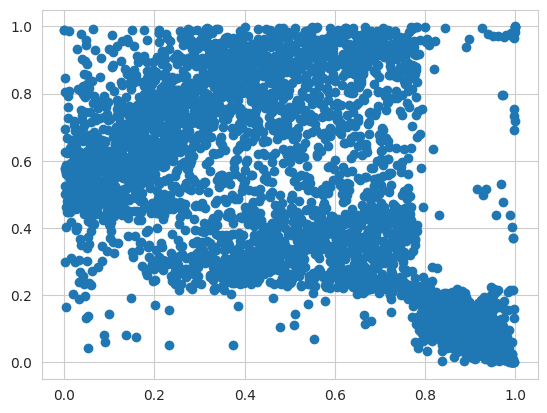

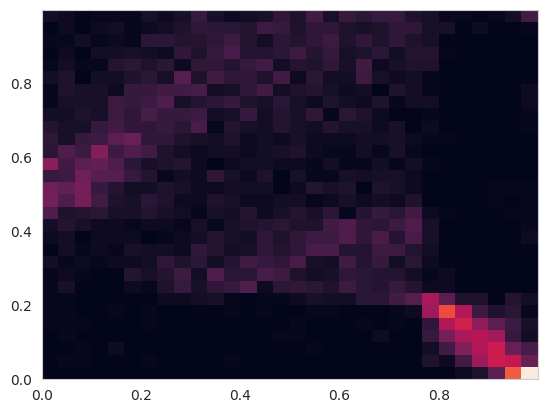

<Figure size 640x480 with 0 Axes>

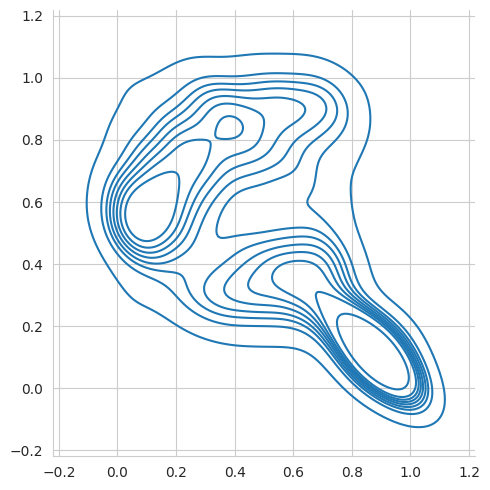

In [9]:
gd = list(filter(lambda x: x['Name'] == 'socfb-Bucknell39', do_feature_extract.graph_dicts))[0]
in_path = gd['FullPath']
in_path
name = gd['Name']
g = networkit.readGraph(in_path, networkit.Format.EdgeListSpaceOne)
g = utils.get_largest_component(g)
nk.overview(g)
n = g.numberOfNodes()

mcmc.quick_2dhistplot(g)

'/cluster/scratch/bdayan/GIRG_data/socfb-Brandeis99.SpaceOne'

Network Properties:
nodes, edges			3887, 137561
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.018214
clustering coefficient		0.262845
min/max/avg degree		1, 1972, 70.780036
degree assortativity		-0.027598
number of connected components	1
size of largest component	3887 (100.00 %)


PointsCube([[0.05042449, 0.17545665],
            [0.52122459, 0.17597119],
            [0.68973501, 0.42346282],
            ...,
            [0.92307692, 0.89863648],
            [0.84049395, 0.84280936],
            [0.90892719, 0.92719321]])

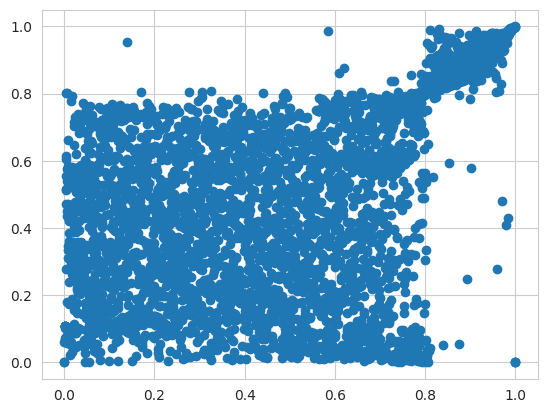

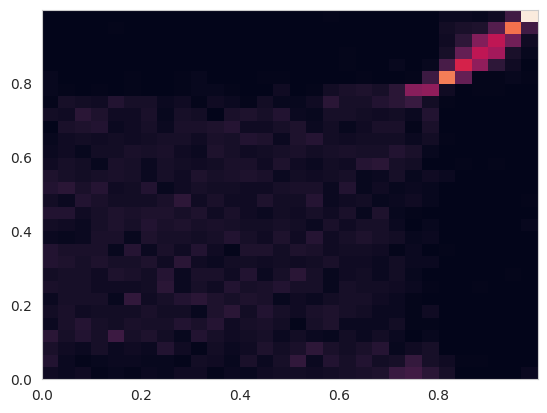

<Figure size 640x480 with 0 Axes>

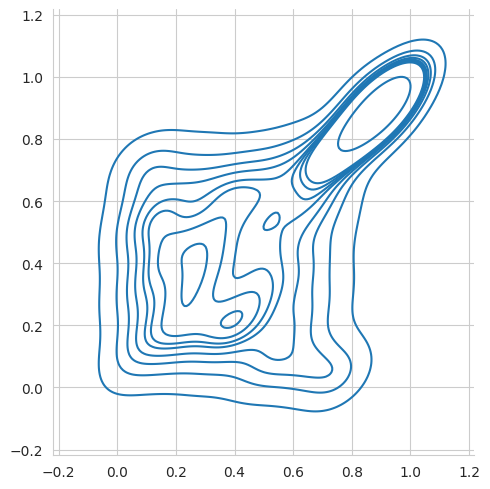

In [10]:
gd = list(filter(lambda x: x['Name'] == 'socfb-Brandeis99', do_feature_extract.graph_dicts))[0]
in_path = gd['FullPath']
in_path
name = gd['Name']
g = networkit.readGraph(in_path, networkit.Format.EdgeListSpaceOne)
g = utils.get_largest_component(g)
nk.overview(g)
n = g.numberOfNodes()

mcmc.quick_2dhistplot(g)

'/cluster/scratch/bdayan/GIRG_data/socfb-Lehigh96.SpaceOne'

Network Properties:
nodes, edges			5073, 198346
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.015417
clustering coefficient		0.266552
min/max/avg degree		1, 973, 78.196728
degree assortativity		0.035503
number of connected components	1
size of largest component	5073 (100.00 %)


PointsCube([[0.30553913, 0.47309284],
            [0.98738419, 0.04947763],
            [0.36585847, 0.60555884],
            ...,
            [0.15493791, 0.86024049],
            [0.8827124 , 0.24147447],
            [0.30869308, 0.63926671]])

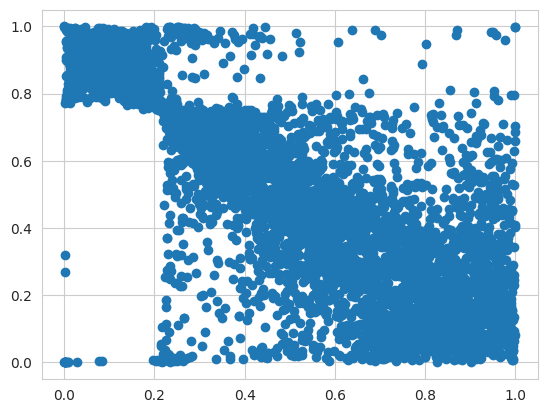

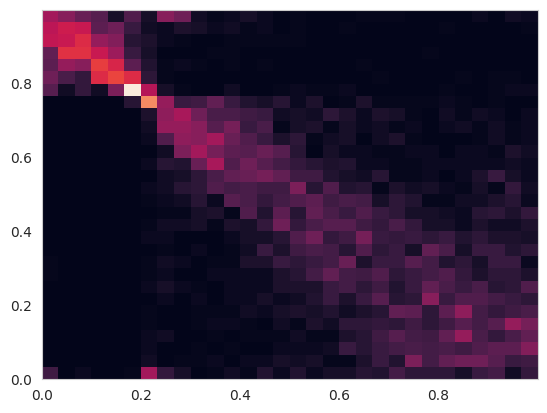

<Figure size 640x480 with 0 Axes>

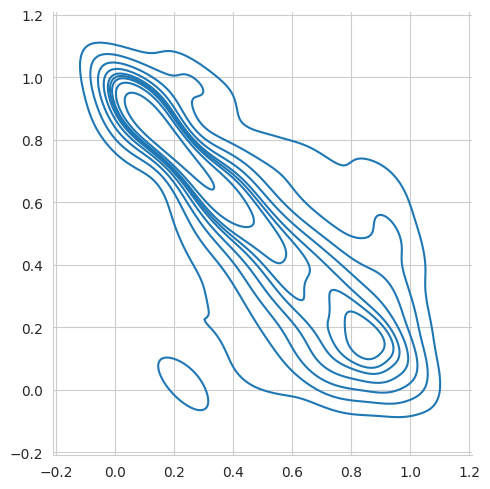

In [12]:
gd = list(filter(lambda x: x['Name'] == 'socfb-Lehigh96', do_feature_extract.graph_dicts))[0]
in_path = gd['FullPath']
in_path
name = gd['Name']
g = networkit.readGraph(in_path, networkit.Format.EdgeListSpaceOne)
g = utils.get_largest_component(g)
nk.overview(g)
n = g.numberOfNodes()

mcmc.quick_2dhistplot(g)

'/cluster/scratch/bdayan/GIRG_data/socfb-Yale4.SpaceOne'

Network Properties:
nodes, edges			8561, 405440
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.011065
clustering coefficient		0.234664
min/max/avg degree		1, 2517, 94.717907
degree assortativity		0.018710
number of connected components	1
size of largest component	8561 (100.00 %)


PointsCube([[0.72631702, 0.55939727],
            [0.57832029, 0.4334774 ],
            [0.27193085, 0.14052097],
            ...,
            [0.88213994, 0.56523771],
            [0.85036795, 0.28629833],
            [0.08632169, 0.90117977]])

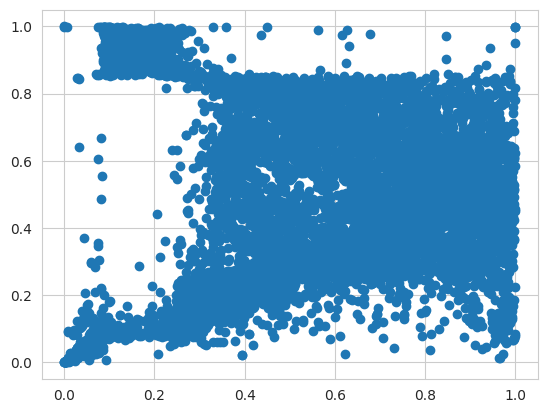

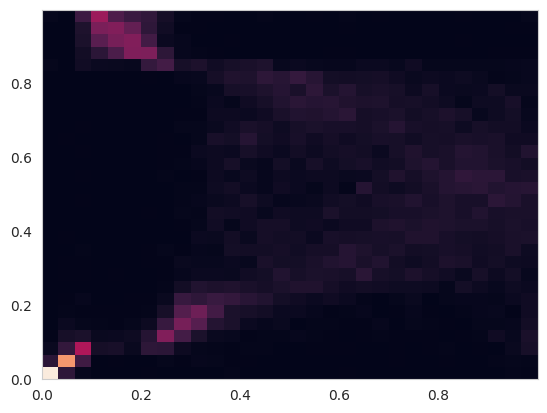

<Figure size 640x480 with 0 Axes>

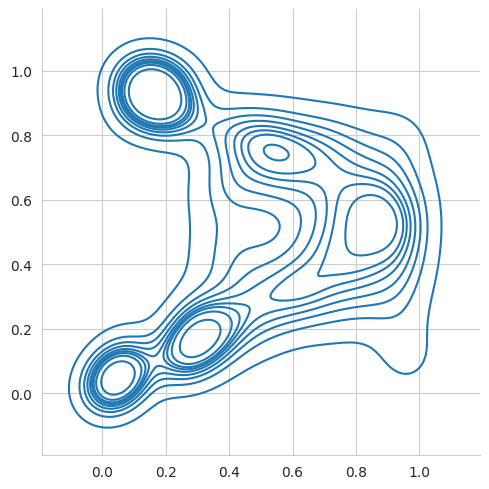

In [13]:
gd = list(filter(lambda x: x['Name'] == 'socfb-Yale4', do_feature_extract.graph_dicts))[0]
in_path = gd['FullPath']
in_path
name = gd['Name']
g = networkit.readGraph(in_path, networkit.Format.EdgeListSpaceOne)
g = utils.get_largest_component(g)
nk.overview(g)
n = g.numberOfNodes()

mcmc.quick_2dhistplot(g)

'/cluster/scratch/bdayan/GIRG_data/socfb-Cal65.SpaceOne'

Network Properties:
nodes, edges			11243, 351356
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.005560
clustering coefficient		0.227561
min/max/avg degree		1, 415, 62.502179
degree assortativity		0.191620
number of connected components	1
size of largest component	11243 (100.00 %)


PointsCube([[0.50609268, 0.83998933],
            [0.71315485, 0.20697323],
            [0.0038246 , 0.00355777],
            ...,
            [0.21239883, 0.37810193],
            [0.46197634, 0.88179312],
            [0.12888019, 0.12007471]])

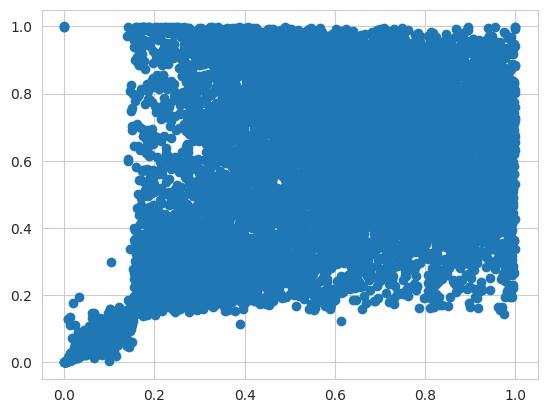

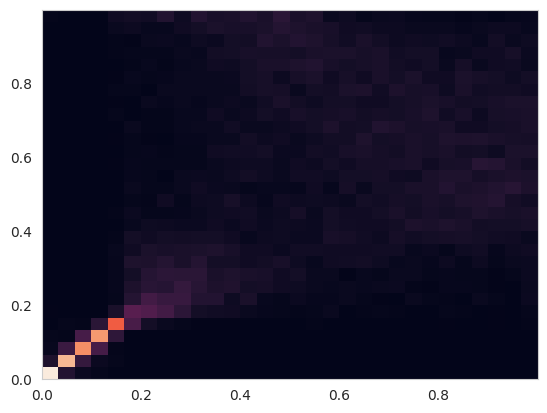

<Figure size 640x480 with 0 Axes>

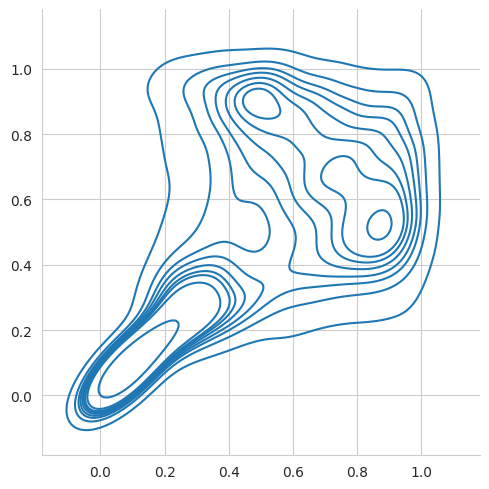

In [14]:
gd = list(filter(lambda x: x['Name'] == 'socfb-Cal65', do_feature_extract.graph_dicts))[0]
in_path = gd['FullPath']
in_path
name = gd['Name']
g = networkit.readGraph(in_path, networkit.Format.EdgeListSpaceOne)
g = utils.get_largest_component(g)
nk.overview(g)
n = g.numberOfNodes()

mcmc.quick_2dhistplot(g)

In [10]:
gd = list(filter(lambda x: x['Name'] == 'socfb-American75', do_feature_extract.graph_dicts))[0]
in_path = gd['FullPath']
in_path
name = gd['Name']
g = networkit.readGraph(in_path, networkit.Format.EdgeListSpaceOne)
g = utils.get_largest_component(g)
nk.overview(g)
n = g.numberOfNodes()

'/cluster/scratch/bdayan/GIRG_data/socfb-American75.SpaceOne'

Network Properties:
nodes, edges			6370, 217654
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.010730
clustering coefficient		0.240782
min/max/avg degree		1, 930, 68.337206
degree assortativity		0.066466
number of connected components	1
size of largest component	6370 (100.00 %)


In [22]:
import importlib
importlib.reload(mcmc)
from tests import test_mcmc

<module 'benji_girgs.mcmc' from '../benji_girgs/mcmc.py'>

In [23]:
temp = mcmc.quick_2dhistplot(g)
temp.shape

(6370, 2)

In [11]:
g, A, weights, const, pts_diffmap, pts_init, MC, MC_init = mcmc.g_diffmap_initialised_mcmc(g, alpha=alpha, const=const, pts_d=2)

/cluster/apps/nss/gcc-6.3.0/python/3.8.5/x86_64/lib64/python3.8/multiprocessing/sharedctypes.py:67: ComplexWarning: Casting complex values to real discards the imaginary part
  result.__init__(*size_or_initializer)
../benji_girgs/generation.py:78: RuntimeWarning: divide by zero encountered in true_divide
  p_uv = np.divide(wuwv, dists**d)


In [14]:
g_dm, A_dm = test_mcmc.MC_to_g_A(MC)
g_init, A_init = test_mcmc.MC_to_g_A(MC_init)

nk.overview(g_dm)
nk.overview(g_init)

CM = test_mcmc.quick_acc(A, A_dm)
CM
test_mcmc.quick_summarise_CM(CM)
print('============')
CM = test_mcmc.quick_acc(A, A_init)
CM
test_mcmc.quick_summarise_CM(CM)
':)'

const_in: 0.1920985327148446


../benji_girgs/generation.py:65: RuntimeWarning: divide by zero encountered in true_divide
  p_uv = np.divide(outer, dists**d)
../benji_girgs/generation.py:442: RuntimeWarning: divide by zero encountered in true_divide
  puv = np.stack([np.ones(original_edge_dists.shape), const_in * ((wu * wv / W) / original_edge_dists ** d) ** alpha]).min(axis=0)
../benji_girgs/generation.py:443: RuntimeWarning: divide by zero encountered in true_divide
  puv_cube = np.stack([np.ones(cube_edge_dists.shape), const_in * ((wu * wv / W) / cube_edge_dists ** d) ** alpha]).min(axis=0)


const_in: 0.1920985327148446
Network Properties:
nodes, edges			6370, 401341
directed?			False
weighted?			False
isolated nodes			48
self-loops			0
density				0.019785
clustering coefficient		0.301776
min/max/avg degree		0, 1008, 126.009733
degree assortativity		0.152800
number of connected components	52
size of largest component	6316 (99.15 %)
Network Properties:
nodes, edges			6370, 213225
directed?			False
weighted?			False
isolated nodes			52
self-loops			0
density				0.010511
clustering coefficient		0.237732
min/max/avg degree		0, 671, 66.946625
degree assortativity		0.025984
number of connected components	53
size of largest component	6318 (99.18 %)


array([[0.00147163, 0.00925635],
       [0.01831012, 0.9709619 ]])

array([[0.13717644, 0.86282356],
       [0.01850868, 0.98149132]])

array([[3.33095924e-04, 1.03948798e-02],
       [1.01765783e-02, 9.79095446e-01]])

array([[0.03104928, 0.96895072],
       [0.01028694, 0.98971306]])

':)'

<Figure size 640x480 with 0 Axes>

(array([[ 84.,   3.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   2.,
           1.,   0.,   0.,   0.,   0.,   0.,   0., 120.],
        [  4.,   6.,   5.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           1.,   8.,  12.,   6.,   4.,   5., 100.,  59.],
        [  2.,   2.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           2.,   8.,   6.,   9.,  19.,  98.,  63.,   2.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           1.,   8.,  12.,  35.,  86.,  68.,   1.,   1.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           5.,  17

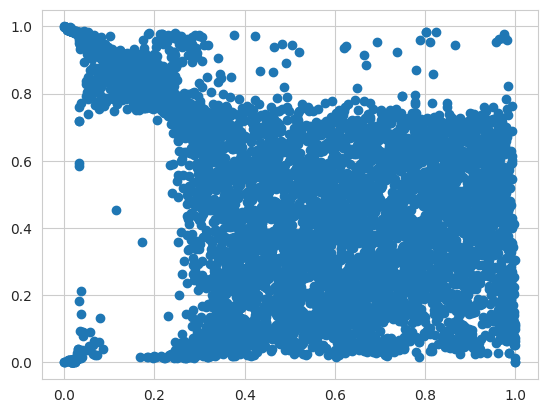

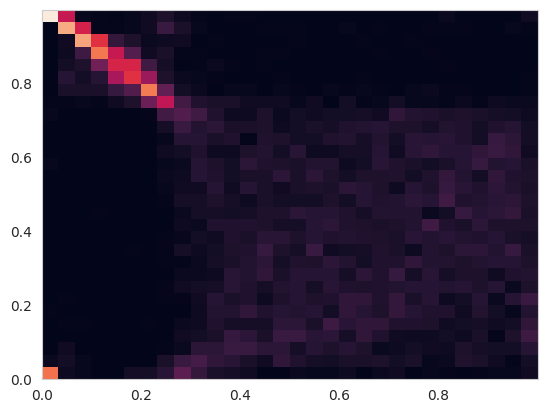

In [15]:
%matplotlib inline
# a = MC.pts[:, 0]
# plt.hist(a[a<0.04], bins=50)

plt.scatter(MC.pts[:, 0], MC.pts[:, 1])
plt.figure()
plt.hist2d(MC.pts[:, 0], MC.pts[:, 1], bins=30)

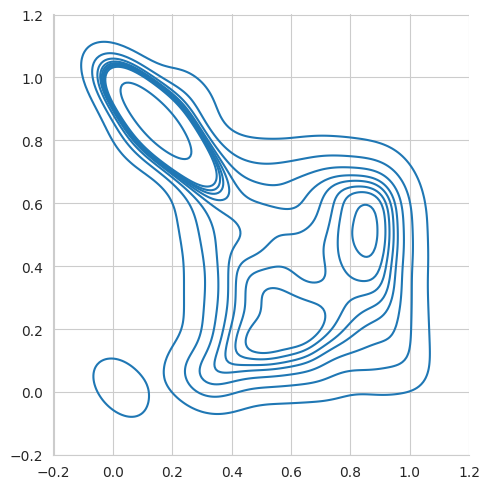

In [20]:
import seaborn as sns
sns.displot(x=MC.pts[:, 0], y=MC.pts[:, 1], kind="kde")

In [17]:
np.sum(MC.pts[:, 0] < 0.3)

PointsCube(1911)

In [18]:
np.sum(MC.pts[:, 1] > 0.68)

PointsCube(2038)

In [19]:
MC.pts.shape

(6370, 2)

In [64]:
# MC.const = 0.00000000001
# MC.const_in = generation.const_conversion(MC.const, MC.alpha, d=1)
# g_dm, A_dm = test_mcmc.MC_to_g_A(MC)
# nk.overview(g_dm)

const_in: 9.660809230043631e-13
Network Properties:
nodes, edges			3745, 87188
directed?			False
weighted?			False
isolated nodes			109
self-loops			0
density				0.012437
clustering coefficient		0.947397
min/max/avg degree		0, 106, 46.562350
degree assortativity		1.000000
number of connected components	298
size of largest component	107 (2.86 %)


In [56]:
nk.overview(g)

Network Properties:
nodes, edges			3745, 81901
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.011682
clustering coefficient		0.281814
min/max/avg degree		1, 419, 43.738852
degree assortativity		0.142167
number of connected components	1
size of largest component	3745 (100.00 %)


In [65]:
# MC.const
# MC.const_in = generation.const_conversion(MC.const, MC.alpha, d=2)
# MC.const_in
# MC.pts = pts_diffmap.copy()
# MC.num_steps = 0
# MC.num_acceptances=0
# MC.ll_steps = [0]
# MC.ll = MC.calculate_ll()
# MC.lls = [MC.ll]
# MC.pts = pts_diffmap.copy()

1e-11

4.4356330039837957e-13

../benji_girgs/points.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  return 2*get_dist_cube(self.astype(np.float16), other.astype(np.float16), b_vec=b_vec)


In [66]:
MC.ll

-5284512.445745433

In [67]:
g_dm, A_dm = test_mcmc.MC_to_g_A(MC)
CM = test_mcmc.quick_acc(A, A_dm)
CM
test_mcmc.quick_summarise_CM(CM)
print('============')
CM = test_mcmc.quick_acc(A, A_init)
CM
test_mcmc.quick_summarise_CM(CM)
':)'

const_in: 9.660809230043631e-13


../benji_girgs/points.py:68: ComplexWarning: Casting complex values to real discards the imaginary part
  return 2*get_dists(self.astype(np.float16), self.astype(np.float16), b_vec=b_vec)
../benji_girgs/points.py:71: ComplexWarning: Casting complex values to real discards the imaginary part
  return 2*get_dist(self.astype(np.float16), other.astype(np.float16), b_vec=b_vec)


array([[3.67771180e-04, 1.13114950e-02],
       [1.20654330e-02, 9.76255301e-01]])

array([[0.03148924, 0.96851076],
       [0.01220801, 0.98779199]])

array([[5.33189780e-04, 1.11460764e-02],
       [1.11949890e-02, 9.77125745e-01]])

array([[0.04565268, 0.95434732],
       [0.01132728, 0.98867272]])

':)'

In [31]:
g_dm, A_dm = test_mcmc.MC_to_g_A(MC)
CM = test_mcmc.quick_acc(A, A_dm)
CM
test_mcmc.quick_summarise_CM(CM)
print('============')
CM = test_mcmc.quick_acc(A, A_init)
CM
test_mcmc.quick_summarise_CM(CM)
':)'

const_in: 7.903612372398382e-06


array([[0.00545462, 0.02788306],
       [0.02316523, 0.94349709]])

array([[0.16361719, 0.83638281],
       [0.02396414, 0.97603586]])

array([[0.00328691, 0.03005077],
       [0.04226015, 0.92440217]])

array([[0.09859455, 0.90140545],
       [0.04371759, 0.95628241]])

':)'

In [31]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

<IPython.core.display.Javascript object>

In [32]:
MC.run_pool(10000, pool_size=15, jobs_per_worker=10, plot_every=3000)

10050it [00:40, 249.92it/s]                          


<Figure size 640x480 with 0 Axes>

(array([[ 4.,  2.,  3.,  4.,  4.,  3.,  5.,  5.,  1.,  5.,  3.,  5.,  2.,
          3.,  3.,  6.,  5.,  6.,  4.,  6.,  4.,  6.,  7.,  9.,  7.,  8.,
          4.,  8.,  9.,  4.],
        [ 7.,  1.,  3.,  4.,  1.,  2.,  1.,  4.,  6.,  1.,  7.,  2.,  8.,
          4.,  5.,  5.,  3.,  4.,  5.,  2.,  3.,  2.,  4.,  6.,  8.,  3.,
          6.,  9.,  9.,  6.],
        [ 2.,  2.,  5.,  2.,  3.,  3.,  2.,  1.,  1.,  4.,  2.,  0.,  4.,
          3.,  4.,  5.,  1.,  2.,  3.,  3.,  7.,  6.,  5.,  5.,  6.,  5.,
          7., 10.,  8.,  6.],
        [ 4.,  2.,  6.,  2.,  2.,  1.,  5.,  5.,  6.,  2.,  1.,  4.,  5.,
          4.,  4.,  5.,  3.,  3.,  6.,  5.,  4.,  4.,  5.,  4.,  5.,  3.,
          9.,  7.,  9.,  5.],
        [ 4.,  3.,  1.,  5.,  5.,  0.,  2.,  3.,  2.,  3.,  4.,  3.,  5.,
          3.,  2.,  4.,  2.,  7.,  3.,  5.,  4.,  4.,  5.,  7.,  4.,  5.,
          8.,  5.,  7.,  4.],
        [ 2.,  1.,  3.,  4.,  3.,  3.,  4.,  4.,  6.,  1.,  4.,  2.,  5.,
          3.,  6.,  4.,  4.,  5.,  4

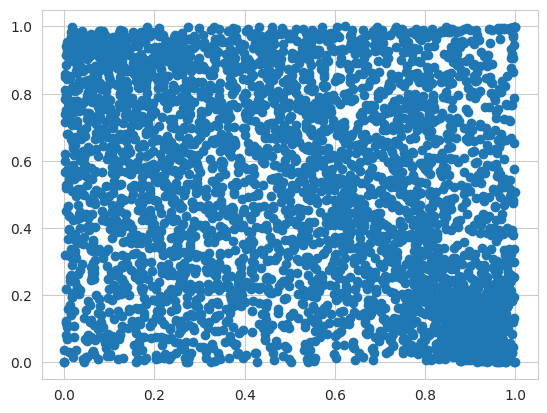

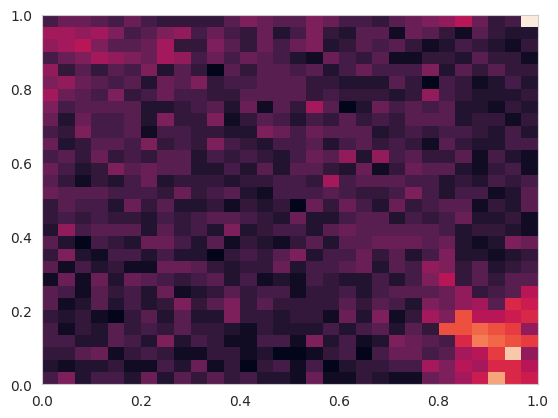

In [33]:
%matplotlib inline
# a = MC.pts[:, 0]
# plt.hist(a[a<0.04], bins=50)

plt.scatter(MC.pts[:, 0], MC.pts[:, 1])
plt.figure()
plt.hist2d(MC.pts[:, 0], MC.pts[:, 1], bins=30)

In [ ]:
g_dm, A_dm = test_mcmc.MC_to_g_A(MC)
# g_init, A_init = test_mcmc.MC_to_g_A(MC_init)

nk.overview(g_dm)
nk.overview(g_init)

CM = test_mcmc.quick_acc(A, A_dm)
CM
test_mcmc.quick_summarise_CM(CM)
print('============')
CM = test_mcmc.quick_acc(A, A_init)
CM
test_mcmc.quick_summarise_CM(CM)
':)'

In [ ]:
MC.plot_ll(MC.num_steps)

In [26]:
MC.calculate_ll()

-1202958.4914603485

In [102]:
MC.ll_steps

[0,
 0,
 1,
 2,
 4,
 5,
 6,
 7,
 12,
 13,
 15,
 16,
 17,
 18,
 23,
 24,
 26,
 27,
 28,
 29,
 31,
 32,
 34,
 36,
 39,
 44,
 45,
 49,
 55,
 57,
 58,
 61,
 67,
 73,
 74,
 78,
 80,
 81,
 82,
 83,
 84,
 86,
 87,
 89,
 91,
 92,
 93,
 94,
 97,
 98,
 99,
 101,
 107,
 112,
 114,
 115,
 116,
 122,
 123,
 124,
 125,
 131,
 134,
 135,
 136,
 137,
 139,
 140,
 142,
 143,
 144,
 145,
 155,
 156,
 157,
 158,
 160,
 161,
 162,
 167,
 168,
 169,
 170,
 172,
 175,
 176,
 177,
 179,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 189,
 190,
 194,
 195,
 198,
 202,
 203,
 204,
 205,
 208,
 211,
 212,
 214,
 215,
 217,
 218,
 219,
 221,
 222,
 226,
 227,
 228,
 229,
 230,
 231,
 233,
 234,
 236,
 237,
 241,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 253,
 256,
 257,
 259,
 263,
 264,
 266,
 267,
 273,
 275,
 276,
 277,
 280,
 285,
 286,
 288,
 289,
 290,
 291,
 297,
 300,
 301,
 302,
 303,
 305,
 307,
 308,
 311,
 312,
 315,
 316,
 319,
 320,
 325,
 326,
 331,
 333,
 340,
 342,
 344,
 345,
 346,
 347,
 34

In [81]:
MC.calculate_ll()

-1197406.9692224392

In [77]:
MC.calculate_ll()

-1199493.5638940108

In [44]:
def mcmc_girg_init_worker(pts, pts_shape, pts_init, weights, g):
    mp_var_dict = mcmc.mp_var_dict
    mp_var_dict['pts'] = pts
    mp_var_dict['pts_shape'] = pts_shape
    # mp_var_dict['pts_init'] = None
    if 'pts_init' in mp_var_dict:
        del(mp_var_dict['pts_init'])
    mp_var_dict['weights'] = weights
    mp_var_dict['g'] = g

mcmc.mcmc_girg_init_worker = mcmc_girg_init_worker

In [43]:
foo = {'a': 1}
del(foo['b'])

KeyError: 'b'

In [ ]:

u_index = 100
sigma, p_normal=None, None
if sigma is None:
    sigma = 2 * ((1/n)**1/d)
if p_normal is None:
    p_normal = 0.7

x_u_init = MC.pts_init[u_index]
x_u2 = mcmc.MCMC_girg.proposal(1, d, sigma=sigma, x_u=x_u_init, p_normal=p_normal).squeeze()

def prior_x_u(pt):
    out = p_normal * np.sqrt(1/(2*np.pi) * np.exp(-np.linalg.norm(pt - x_u_init)**2 / (2 * sigma**(2*d))))
    + (1 - p_normal)
    return out
acceptance_prob, u_ll_old, u_ll_new, p_u_to_vs_old, p_u_to_vs_new = mcmc.MCMC_girg.acceptance_prob_static(MC.g, weights, alpha, MC.const_in, MC.pts,
                                                                                    u_index, x_u2, prior_x_u)

In [36]:
x_u2
x_u_init

PointsCube([0.06785322, 0.98485106])

PointsCube([0.06993552, 0.98693336])

In [38]:
prior_x_u(x_u_init)
prior_x_u(x_u2)

0.2792595962810029

0.01796251693731934

In [39]:
pts = MC.pts
eps = 1e-7
p_u_to_vs = generation.get_probs_u(weights, MC.pts, alpha, MC.const_in, u_index)
p_u_to_vs = np.clip(p_u_to_vs, eps, 1 - eps)

x_u = pts[u_index].copy()
pts[u_index] = x_u2
p_u_to_vs2 = generation.get_probs_u(weights, MC.pts, alpha, MC.const_in, u_index)
pts[u_index] = x_u
p_u_to_vs2 = np.clip(p_u_to_vs2, eps, 1 - eps)

u_ll_old = mcmc.MCMC_girg.p_u_to_vs_to_ll(g, u_index, p_u_to_vs)
u_ll_new = mcmc.MCMC_girg.p_u_to_vs_to_ll(g, u_index, p_u_to_vs2)

In [41]:
u_ll_old
u_ll_new

-28842.560305343573

-29101.628442570873

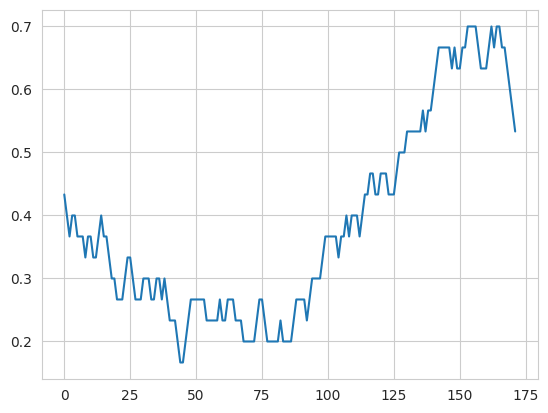

In [37]:
%matplotlib inline
MC.acceptances_plot(convolve_width=30)

In [48]:
g_dm, A_dm = test_mcmc.MC_to_g_A(MC)
CM = test_mcmc.quick_acc(A, A_dm)
CM
test_mcmc.quick_summarise_CM(CM)
print('============')
CM = test_mcmc.quick_acc(A, A_init)
CM
test_mcmc.quick_summarise_CM(CM)
':)'

const_in: 7.903612372398382e-06


array([[0.00569284, 0.02764484],
       [0.02499793, 0.9416644 ]])

array([[0.17076292, 0.82923708],
       [0.02586004, 0.97413996]])

array([[0.00325768, 0.03008   ],
       [0.04177225, 0.92489007]])

array([[0.09771763, 0.90228237],
       [0.04321286, 0.95678714]])

':)'

(0.05, 0.12)

(0.8, 1.0)

<Figure size 640x480 with 0 Axes>

(0.06, 0.08)

(0.875, 1.0)

<Figure size 640x480 with 0 Axes>

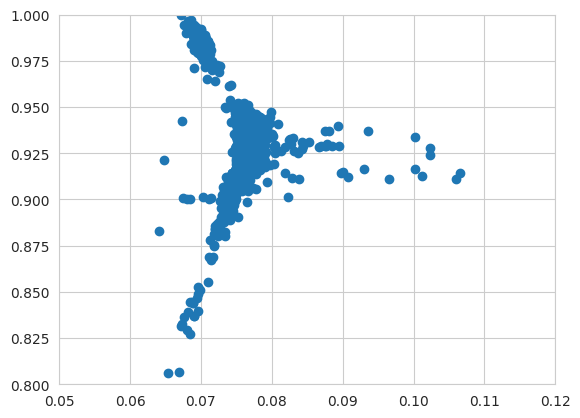

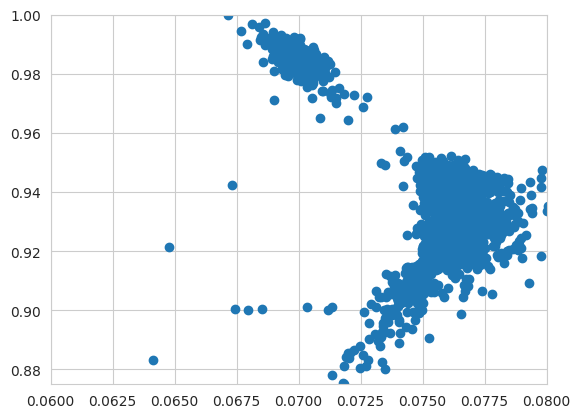

<Figure size 640x480 with 0 Axes>

In [51]:
%matplotlib inline
plt.scatter(MC.pts[:, 0], MC.pts[:, 1])
plt.xlim([0.05, 0.12])
plt.ylim([0.8, 1.0])
plt.figure()

plt.scatter(MC.pts[:, 0], MC.pts[:, 1])
plt.xlim([0.06, 0.08])
plt.ylim([0.875, 1.0])
plt.figure()

# plt.hist2d(MC.pts[:, 0], MC.pts[:, 1], bins=1000)
# plt.xlim([0.06, 0.09])
# plt.ylim([0.0, 0.2])

(array([277., 194., 210., 217., 244., 223., 230., 223., 205., 227.]),
 array([0.        , 0.09999247, 0.19998495, 0.29997742, 0.3999699 ,
        0.49996237, 0.59995485, 0.69994732, 0.7999398 , 0.89993227,
        0.99992474]),
 <BarContainer object of 10 artists>)

<Figure size 640x480 with 0 Axes>

(array([252., 203., 214., 247., 237., 234., 221., 202., 216., 224.]),
 array([0.        , 0.09990712, 0.19981424, 0.29972137, 0.39962849,
        0.49953561, 0.59944273, 0.69934986, 0.79925698, 0.8991641 ,
        0.99907122]),
 <BarContainer object of 10 artists>)

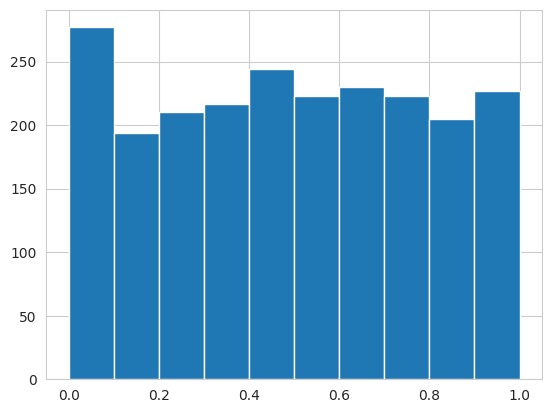

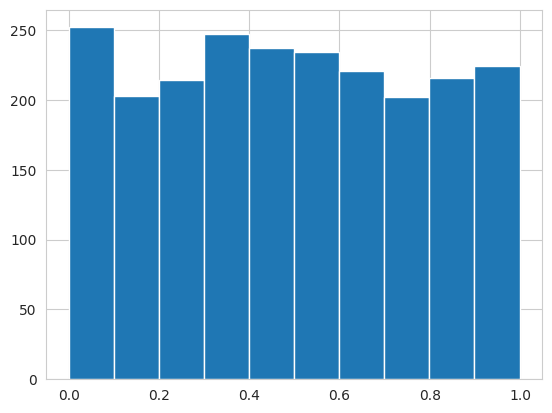

In [52]:
%matplotlib inline
plt.hist(MC.pts[:, 0])
plt.figure()
plt.hist(MC.pts[:, 1])


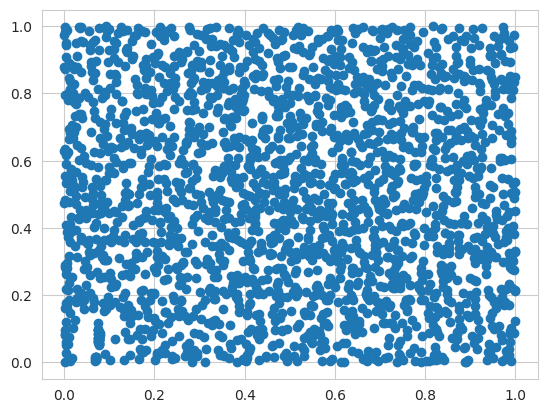

In [53]:
plt.scatter(MC.pts[:, 0], MC.pts[:, 1])

In [16]:
g_mc, A_mc = test_mcmc.MC_to_g_A(MC)
nk.overview(g_mc)

const_in: 0.17931646322859224
Network Properties:
nodes, edges			2250, 75074
directed?			False
weighted?			False
isolated nodes			14
self-loops			0
density				0.029672
clustering coefficient		0.313861
min/max/avg degree		0, 449, 66.732444
degree assortativity		0.071144
number of connected components	15
size of largest component	2236 (99.38 %)


In [17]:
CM = test_mcmc.quick_acc(A, A_mc)
CM
test_mcmc.quick_summarise_CM(CM)

CM = test_mcmc.quick_acc(A, A_init)
CM
test_mcmc.quick_summarise_CM(CM)

':('

array([[0.0024798 , 0.03085788],
       [0.02717906, 0.93948326]])

array([[0.07438438, 0.92561562],
       [0.0281164 , 0.9718836 ]])

':('

In [9]:
a = df.loc[:, ['Graph', 'Model', 'Nodes', 'Info']]
a

Graph                    Model  Nodes  \
0         socfb-Caltech36  1d-copyweight-cube-girg    756   
1            socfb-Reed98  1d-copyweight-cube-girg    955   
2         socfb-Caltech36  2d-copyweight-cube-girg    757   
3         socfb-Simmons81  1d-copyweight-cube-girg   1497   
4       socfb-Haverford76  1d-copyweight-cube-girg   1440   
..                    ...                      ...    ...   
157       socfb-Bingham82  2d-copyweight-cube-girg   9945   
158         socfb-Maine59  3d-copyweight-cube-girg   9001   
159   socfb-Mississippi66  2d-copyweight-cube-girg  10496   
160    socfb-Georgetown15  3d-copyweight-cube-girg   9341   
161  socfb-Northwestern25  1d-copyweight-cube-girg  10510   

                                                  Info  
0    {'tau': 7.3017225936374555, 'alpha': 1.2171928...  
1    {'tau': 4.381732472502371, 'alpha': 1.07671601...  
2    {'tau': 7.3017225936374555, 'alpha': 1.1949215...  
3    {'tau': 4.739342146243066, 'alpha': 1.16300199...  
4    {'tau': 6.5461700448727616, 'alpha': 1.0592519...  
..                                                 ...  
157  {'tau': 5.959769046529775, 'alpha': 1.07671601...  
158  {'tau': 5.253031117549527, 'alpha': 1.10401932...  
159  {'tau': 5.425199038576664, 'alpha': 1.05073058...  
160  {'tau': 4.898184083615165, 'alpha': 1.04234527...  
161  {'tau': 5.650649065012116, 'alpha': 1.07229622...  

[162 rows x 4 columns]

In [21]:
a.loc[a.Graph == 'socfb-Pepperdine86']

Graph                    Model  Nodes  \
41  socfb-Pepperdine86  1d-copyweight-cube-girg   3430   
53  socfb-Pepperdine86  2d-copyweight-cube-girg   3426   
67  socfb-Pepperdine86  3d-copyweight-cube-girg   3430   

                                                 Info  
41  {'tau': 5.27297948141534, 'alpha': 1.059251903...  
53  {'tau': 5.27297948141534, 'alpha': 1.025969862...  
67  {'tau': 5.27297948141534, 'alpha': 1.010101010...

In [22]:
df.iloc[41].Info

{'tau': 5.27297948141534,
 'alpha': 1.0592519033432637,
 'const': 0.10914879350912529,
 'target_lcc': 0.27697571394183823,
 'fit_lcc': 0.2790005420603239,
 'fitting_time': 180.74201369285583,
 'hist': [(2.0, 0.614930496642529),
  (1.342281879194631, 0.42023462193045735),
  (1.1527377521613833, 0.3257112505037432),
  (1.0767160161507403, 0.2855294469587692),
  (1.0423452768729642, 0.26787251887177715),
  (1.0592519033432637, 0.2766223208246902),
  (1.0679125646587686, 0.28514010229395503),
  (1.0592519033432637, 0.2766223208246902)]}

In [23]:
df.iloc[53].Info

{'tau': 5.27297948141534,
 'alpha': 1.0259698621353,
 'const': 0.059451413878825084,
 'target_lcc': 0.27697571394183823,
 'fit_lcc': 0.2748780151815607,
 'fitting_time': 289.33652424812317,
 'hist': [(2.0, 0.5849583176785574),
  (1.342281879194631, 0.4251694982750488),
  (1.1527377521613833, 0.3434494442734461),
  (1.0767160161507403, 0.30518489387359304),
  (1.0423452768729642, 0.2834073963759906),
  (1.0259698621353, 0.274660388413119),
  (1.0340927451930846, 0.28050691796757915),
  (1.0259698621353, 0.274660388413119)]}

In [32]:
import importlib
importlib.reload(test_mcmc)

<module 'tests.test_mcmc' from '../tests/test_mcmc.py'>

In [31]:
# gd = do_feature_extract.graph_dicts[21]

gd = list(filter(lambda x: x['Name'] == 'socfb-Pepperdine86', do_feature_extract.graph_dicts))[0]

in_path = gd['FullPath']
in_path
name = gd['Name']
g = networkit.readGraph(in_path, networkit.Format.EdgeListSpaceOne)
g = utils.get_largest_component(g)
nk.overview(g)
n = g.numberOfNodes()

alpha = df.iloc[53].Info['alpha']
const = df.iloc[53].Info['const']

'/cluster/scratch/bdayan/GIRG_data/socfb-Pepperdine86.SpaceOne'

Network Properties:
nodes, edges			3440, 152003
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.025698
clustering coefficient		0.276976
min/max/avg degree		1, 674, 88.373837
degree assortativity		0.055527
number of connected components	1
size of largest component	3440 (100.00 %)


In [33]:
g, A, weights, const, pts_diffmap, pts_init, MC, MC_init = test_mcmc.test_diffmap_on_g(g, alpha=alpha, const=const, pts_d=2)

../benji_girgs/generation.py:78: RuntimeWarning: divide by zero encountered in true_divide
  p_uv = np.divide(wuwv, dists**d)


In [34]:
g_dm, A_dm = test_mcmc.MC_to_g_A(MC)
g_init, A_init = test_mcmc.MC_to_g_A(MC_init)
nk.overview(g_dm)
nk.overview(g_init)

CM = test_mcmc.quick_acc(A, A_dm)
CM
test_mcmc.quick_summarise_CM(CM)
print('============')
CM = test_mcmc.quick_acc(A, A_init)
CM
test_mcmc.quick_summarise_CM(CM)
':)'


const_in: 0.22909876856987865


../benji_girgs/generation.py:65: RuntimeWarning: divide by zero encountered in true_divide
  p_uv = np.divide(outer, dists**d)
../benji_girgs/generation.py:442: RuntimeWarning: divide by zero encountered in true_divide
  puv = np.stack([np.ones(original_edge_dists.shape), const_in * ((wu * wv / W) / original_edge_dists ** d) ** alpha]).min(axis=0)
../benji_girgs/generation.py:443: RuntimeWarning: divide by zero encountered in true_divide
  puv_cube = np.stack([np.ones(cube_edge_dists.shape), const_in * ((wu * wv / W) / cube_edge_dists ** d) ** alpha]).min(axis=0)


const_in: 0.22909876856987865
Network Properties:
nodes, edges			3440, 2987323
directed?			False
weighted?			False
isolated nodes			12
self-loops			0
density				0.505035
clustering coefficient		0.841734
min/max/avg degree		0, 2699, 1736.815698
degree assortativity		0.354706
number of connected components	13
size of largest component	3428 (99.65 %)
Network Properties:
nodes, edges			3440, 152170
directed?			False
weighted?			False
isolated nodes			15
self-loops			0
density				0.025726
clustering coefficient		0.276121
min/max/avg degree		0, 404, 88.470930
degree assortativity		0.041911
number of connected components	16
size of largest component	3425 (99.56 %)


array([[0.0238051 , 0.00188497],
       [0.48108319, 0.49322674]])

array([[0.92662645, 0.07337355],
       [0.49376812, 0.50623188]])

array([[0.00170988, 0.02398019],
       [0.02400842, 0.95030151]])

array([[0.0665579 , 0.9334421 ],
       [0.02464146, 0.97535854]])

':)'

In [ ]:
MC.run_pool(20000, pool_size=15, jobs_per_worker=15, plot_every=20)

In [4]:
from tests import test_mcmc
from tests.test_mcmc import *
import importlib
importlib.reload(test_mcmc)
g, A, weights, const, pts, pts_diffmap, pts_init, MC, MC_init, MC_cheat = test_mcmc.test_diffmap()

g_dm, A_dm = test_mcmc.MC_to_g_A(MC)
g_init, A_init = test_mcmc.MC_to_g_A(MC_init)
g_cheat, A_cheat = test_mcmc.MC_to_g_A(MC_cheat)


<module 'tests.test_mcmc' from '../tests/test_mcmc.py'>

const_in: 21.744500891857935


../benji_girgs/generation.py:65: RuntimeWarning: divide by zero encountered in true_divide
  p_uv = np.divide(outer, dists**d)
../benji_girgs/generation.py:442: RuntimeWarning: divide by zero encountered in true_divide
  puv = np.stack([np.ones(original_edge_dists.shape), const_in * ((wu * wv / W) / original_edge_dists ** d) ** alpha]).min(axis=0)
../benji_girgs/generation.py:443: RuntimeWarning: divide by zero encountered in true_divide
  puv_cube = np.stack([np.ones(cube_edge_dists.shape), const_in * ((wu * wv / W) / cube_edge_dists ** d) ** alpha]).min(axis=0)
../benji_girgs/generation.py:78: RuntimeWarning: divide by zero encountered in true_divide
  p_uv = np.divide(wuwv, dists**d)


const_in: 21.744500891857935
const_in: 21.744500891857935
const_in: 21.744500891857935


In [6]:
(const*2)**alpha

21.744500891857935

In [7]:
g_temp, _, _, _, _ = generation.generate_GIRG_nk(n, d, tau, alpha, weights=weights, pts=pts, const=const)

const_in: 21.744500891857935


In [8]:
const

6.507705243675296

In [9]:
pts

PointsCube([[0.63956876],
            [0.20144225],
            [0.07984331],
            ...,
            [0.88855468],
            [0.70501783],
            [0.04734976]])

In [10]:
nk.overview(g)
nk.overview(g_temp)

Network Properties:
nodes, edges			1500, 70397
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.062617
clustering coefficient		0.563041
min/max/avg degree		21, 1499, 93.862667
degree assortativity		-0.199725
number of connected components	1
size of largest component	1500 (100.00 %)
Network Properties:
nodes, edges			1500, 70327
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.062555
clustering coefficient		0.562545
min/max/avg degree		18, 1499, 93.769333
degree assortativity		-0.199262
number of connected components	1
size of largest component	1500 (100.00 %)


In [11]:
nk.overview(g_cheat)

Network Properties:
nodes, edges			1500, 70672
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.062861
clustering coefficient		0.560786
min/max/avg degree		21, 1499, 94.229333
degree assortativity		-0.199488
number of connected components	1
size of largest component	1500 (100.00 %)


In [12]:
nk.overview(g_dm)

Network Properties:
nodes, edges			1500, 77445
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.068886
clustering coefficient		0.570072
min/max/avg degree		10, 1499, 103.260000
degree assortativity		-0.197577
number of connected components	1
size of largest component	1500 (100.00 %)


In [18]:
CM = test_mcmc.quick_acc(A, A_cheat)
CM
test_mcmc.quick_summarise_CM(CM)
print('============')
CM = test_mcmc.quick_acc(A, A_dm)
CM
test_mcmc.quick_summarise_CM(CM)
print('============')
CM = test_mcmc.quick_acc(A, A_init)
CM
test_mcmc.quick_summarise_CM(CM)


array([[0.03788   , 0.02469511],
       [0.02493956, 0.91248533]])

array([[0.6053525 , 0.3946475 ],
       [0.02660432, 0.97339568]])

array([[0.03113422, 0.03144089],
       [0.03770578, 0.89971911]])

array([[0.49754961, 0.50245039],
       [0.04022272, 0.95977728]])

array([[0.01840444, 0.04417067],
       [0.04421867, 0.89320622]])

array([[0.29411765, 0.70588235],
       [0.04717036, 0.95282964]])

In [20]:
np.where(A[0, :])

(array([   7,   15,   17,   20,   23,   38,   53,   75,   77,   86,   88,
          89,  113,  141,  166,  176,  216,  224,  247,  251,  252,  271,
         272,  279,  310,  320,  345,  347,  371,  379,  392,  419,  440,
         447,  452,  456,  469,  488,  493,  505,  522,  526,  545,  559,
         572,  574,  606,  612,  614,  621,  625,  643,  648,  653,  658,
         667,  673,  682,  717,  721,  736,  761,  762,  774,  782,  786,
         805,  817,  835,  837,  844,  849,  897,  900,  904,  917,  929,
         932,  941,  943,  949,  956,  960,  964,  968,  978,  997,  999,
        1017, 1019, 1053, 1062, 1087, 1097, 1100, 1117, 1135, 1140, 1150,
        1163, 1165, 1169, 1170, 1183, 1184, 1216, 1228, 1241, 1252, 1269,
        1284, 1321, 1326, 1338, 1345, 1362, 1382, 1383, 1391, 1397, 1402,
        1422, 1477, 1486]),)

In [14]:
list(g.iterNeighbors(0))

[18,
 66,
 98,
 116,
 169,
 176,
 187,
 198,
 260,
 302,
 311,
 343,
 361,
 367,
 1492,
 403,
 413,
 445,
 446,
 456,
 467,
 475,
 476,
 514,
 520,
 523,
 529,
 541,
 576,
 607,
 614,
 662,
 689,
 700,
 717,
 722,
 754,
 769,
 801,
 808,
 841,
 848,
 884,
 888,
 900,
 903,
 913,
 917,
 923,
 938,
 984,
 986,
 991,
 1006,
 1009,
 1015,
 1021,
 1034,
 1041,
 1042,
 1050,
 1051,
 1071,
 1104,
 1114,
 1169,
 1177,
 1179,
 1189,
 1234,
 1235,
 1255,
 1265,
 1297,
 1301,
 1317,
 1333,
 1344,
 1395,
 1438,
 1449,
 1454,
 1456,
 1459,
 1470,
 1472]

In [15]:
list(g_temp.iterNeighbors(0))

[18,
 66,
 75,
 86,
 98,
 116,
 126,
 169,
 173,
 176,
 192,
 194,
 198,
 212,
 229,
 256,
 260,
 302,
 311,
 343,
 361,
 362,
 367,
 403,
 413,
 433,
 446,
 456,
 467,
 476,
 514,
 517,
 521,
 523,
 529,
 607,
 613,
 648,
 692,
 712,
 714,
 722,
 740,
 754,
 764,
 801,
 836,
 841,
 884,
 888,
 900,
 929,
 950,
 984,
 986,
 991,
 1006,
 1050,
 1051,
 1065,
 1071,
 1104,
 1114,
 1169,
 1179,
 1189,
 1198,
 1218,
 1234,
 1235,
 1257,
 1301,
 1313,
 1317,
 1340,
 1344,
 1361,
 1413,
 1434,
 1438,
 1449,
 1454,
 1456,
 1498]

In [16]:
len(list(g_temp.iterNeighbors(0)))
len(list(g.iterNeighbors(0)))

84

86

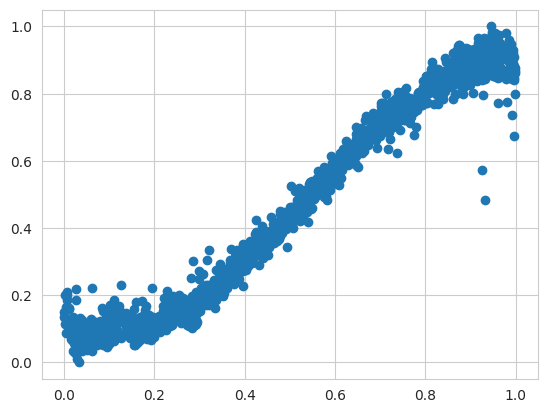

In [6]:
plt.scatter(pts[:, 0], pts_diffmap[:, 0])

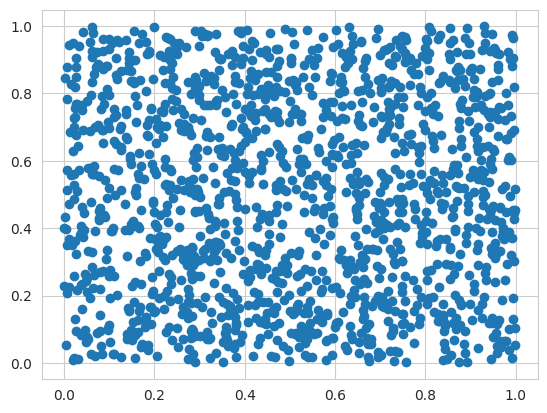

In [7]:
plt.scatter(pts[:, 0], pts_init[:, 0])